In [1]:
%load_ext autoreload
%autoreload 2

## Inference on network trained with x, y, z, yaw

In [2]:
from construct_traj_list import *
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt
import torch

from learning import lstd, valuefunc, trajdata
from env import linearenv, controller
from exputils import relerr
from trajgen import quadratic, nonlinear

/home/anusha/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check if cuda device is available
torch.cuda.current_device()
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.current_device())
torch.cuda.current_device()

11.3
True
0


0

In [42]:
# Load bag with Lissajous curves
bag1 = load_bag('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/inftest6.bag')
ref_traj, actual_traj, input_traj, cost_traj, times = compute_traj(bag1, False)
bag1.close()

Ref traj shape (21124, 14)
Act traj shape (21124, 14)
[]


In [33]:
# Load bag with Lissajous curves
bag2 = load_bag('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/inftest7.bag')
ref_traj1, actual_traj1, input_traj1, cost_traj1, times1 = compute_traj(bag2, False)
bag1.close()

Ref traj shape (19617, 14)
Act traj shape (19617, 14)


In [63]:
# Load bag with Lissajous curves
bag3 = load_bag('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/inftest5.bag')
ref_traj2, actual_traj2, input_traj2, cost_traj2 = compute_traj(bag3, False)
bag1.close()

Ref traj shape (19421, 14)
Act traj shape (19421, 14)


In [44]:
# Load bag with Lissajous curves
bag4 = load_bag('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/inftest10.bag')
ref_traj3, actual_traj3, input_traj3, cost_traj3 = compute_traj(bag3, False)
bag1.close()

Ref traj shape (7842, 14)
Act traj shape (7842, 14)


In [35]:
xcost = np.linalg.norm(actual_traj[:,(0,1,2)] - ref_traj[:,(0,1,2)], axis=1)**2 
ucost = 0.1 * np.linalg.norm(input_traj, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj[:, 12] - ref_traj[:, 12])
ra = np.abs(actual_traj[:, 12] + 2*np.pi-ref_traj[:,12])
yawcost = np.minimum(ar, ra) ** 2
cost = xcost + yawcost + ucost

In [36]:
xcost1 = np.linalg.norm(actual_traj1[:,(0,1,2)] - ref_traj1[:,(0,1,2)], axis=1)**2 
ucost1 = 0.1 * np.linalg.norm(input_traj1, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj1[:, 12] - ref_traj1[:, 12])
ra = np.abs(actual_traj1[:, 12] + 2*np.pi-ref_traj1[:,12])
yawcost1 = np.minimum(ar, ra) ** 2
cost1 = xcost1 + yawcost1 + ucost1

In [66]:
xcost2 = np.linalg.norm(actual_traj2[:,(0,1,2)] - ref_traj2[:,(0,1,2)], axis=1)**2 
ucost2 = 0.1 * np.linalg.norm(input_traj2, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj2[:, 12] - ref_traj2[:, 12])
ra = np.abs(actual_traj2[:, 12] + 2*np.pi-ref_traj2[:,12])
yawcost2 = np.minimum(ar, ra) ** 2
cost2 = xcost2 + yawcost2 + ucost2

In [46]:
xcost3 = np.linalg.norm(actual_traj3[:,(0,1,2)] - ref_traj3[:,(0,1,2)], axis=1)**2 
ucost3 = 0.1 * np.linalg.norm(input_traj3, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj3[:, 12] - ref_traj3[:, 12])
ra = np.abs(actual_traj3[:, 12] + 2*np.pi-ref_traj3[:,12])
yawcost3 = np.minimum(ar, ra) ** 2
cost3 = xcost3 + yawcost3 + ucost3

In [10]:
%matplotlib notebook

## Plot tracking error of actual vs reference trajectory

19617


<IPython.core.display.Javascript object>


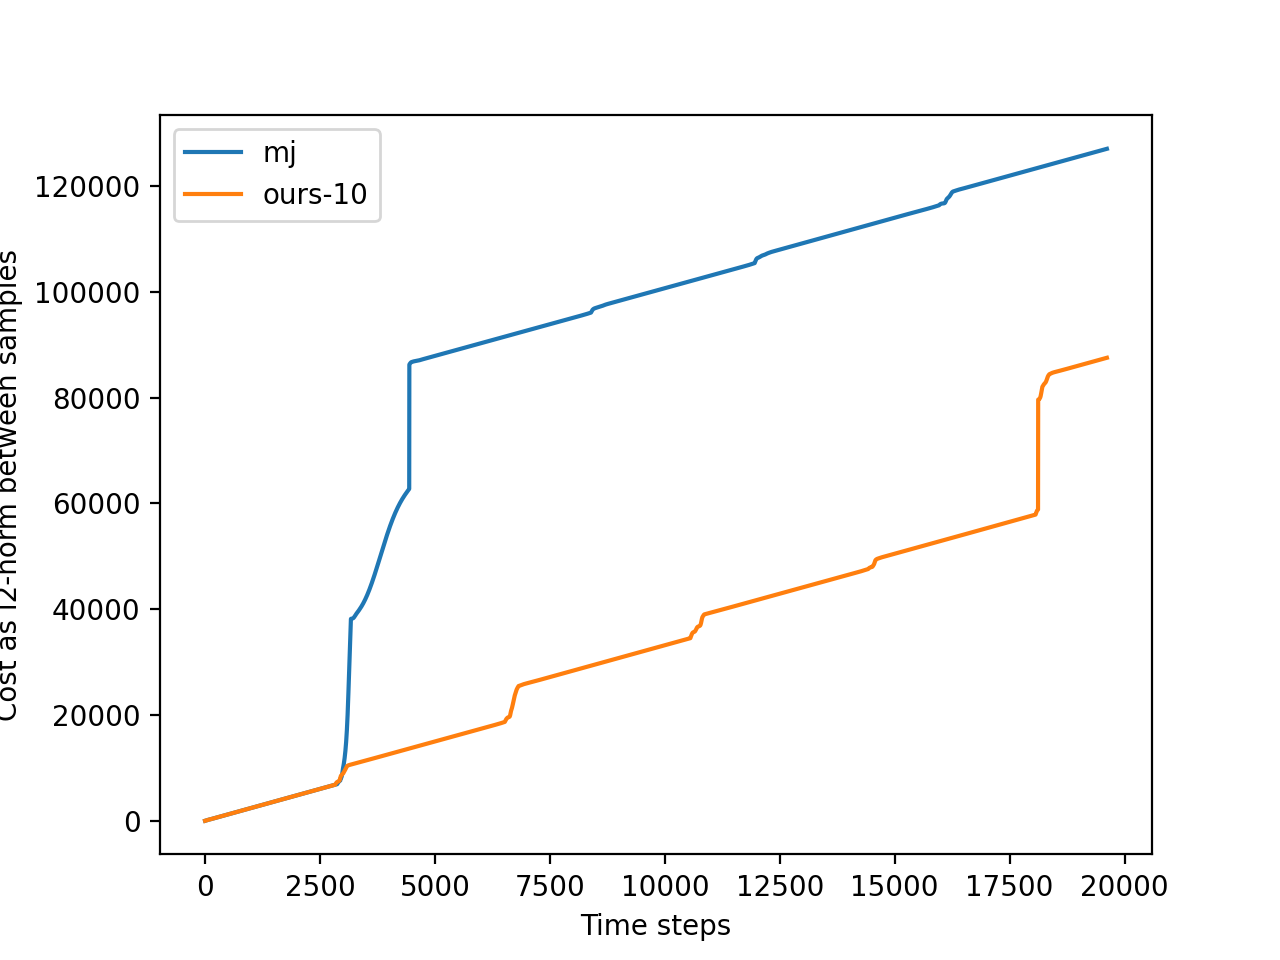

Text(0, 0.5, 'Cost as l2-norm between samples')

In [79]:
Tstart = 0
Tend = cost1.shape[0]
print(Tend)
plt.figure()
#plt.plot(range(Tstart, Tend), cost_traj.ravel()[Tstart:Tend])
plt.plot(range(Tstart, Tend), np.cumsum(cost.ravel()[Tstart:Tend]), label='mj')
plt.plot(range(Tstart, Tend), np.cumsum(cost1.ravel()[Tstart:Tend]), label='ours-10')
# plt.plot(range(Tstart, Tend), np.cumsum(cost2.ravel()[Tstart:Tend]), label='ours-1')
# t.plot(range(Tstart, Tend), np.cumsum(cost3.ravel()[Tstart:Tend]), label='mk')
plt.legend()
plt.xlabel("Time steps")
plt.ylabel("Cost as l2-norm between samples")

8026


<IPython.core.display.Javascript object>


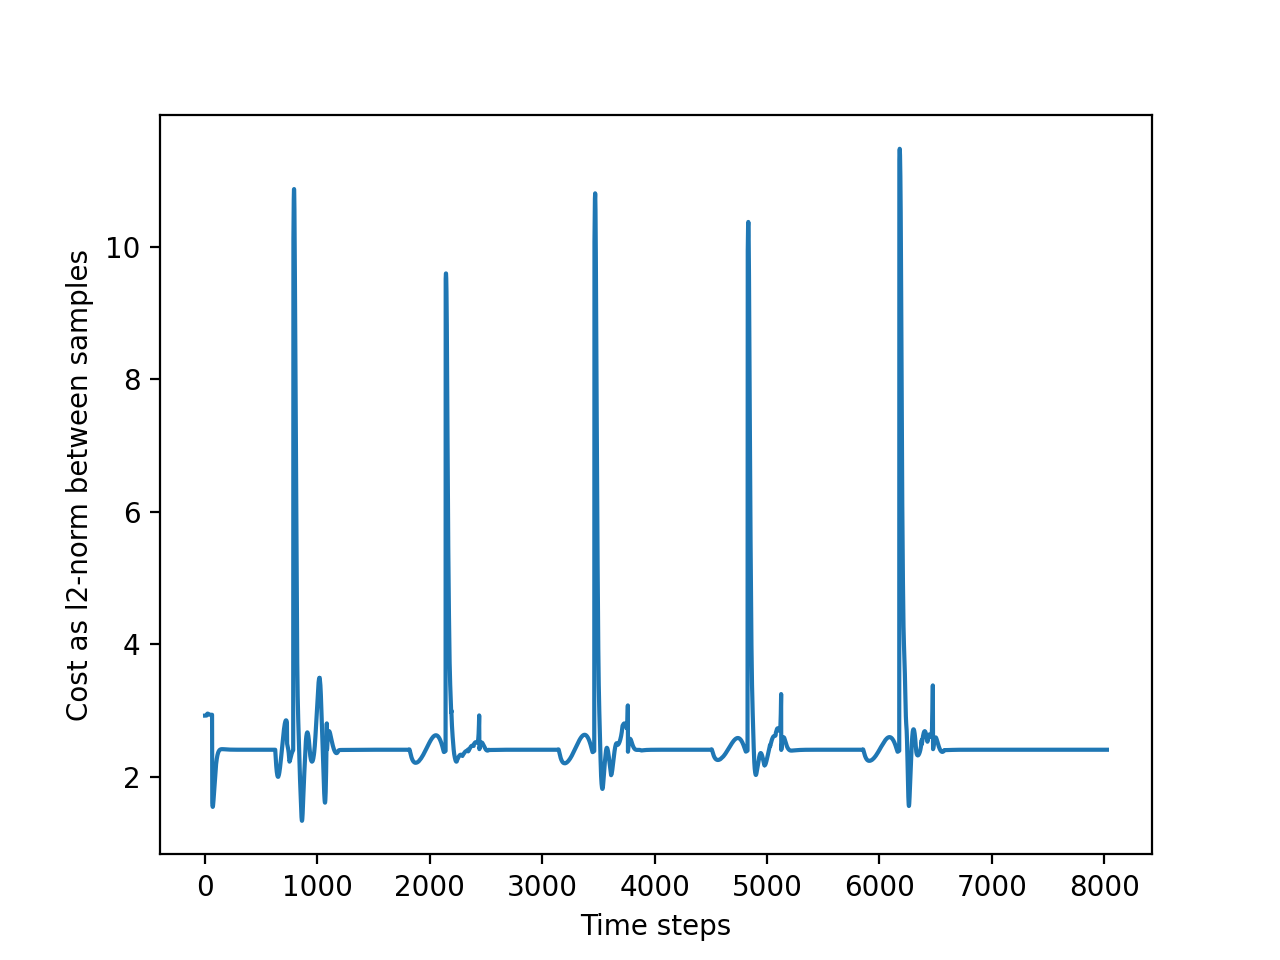

Text(0, 0.5, 'Cost as l2-norm between samples')

In [26]:
Tstart = 0
Tend = cost_traj1.shape[0]
print(Tend)
plt.figure()
plt.plot(range(Tstart, Tend), cost_traj1.ravel()[Tstart:Tend])
plt.xlabel("Time steps")
plt.ylabel("Cost as l2-norm between samples")

## Load all bags and save traj

In [32]:
## Load mj bags and save traj
import pickle

num_bags = 5
traj = []

for i in range(num_bags):
    bag = load_bag('/home/anusha/Research/ws_kr/src/multi_mav_manager/kr_multi_mav_manager/scripts/mj_lissajous_' + str(i) +'.bag')
    ref_traj, actual_traj, input_traj, cost_traj = compute_traj(bag, False)
    traj.append([np.array(ref_traj), np.array(actual_traj), np.array(input_traj)])

# Save list to a numpy text file
with open('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/traj_mj_data.pickle', 'wb') as handle:
    pickle.dump(traj, handle, protocol=pickle.HIGHEST_PROTOCOL)


FileNotFoundError: [Errno 2] No such file or directory: '/home/anusha/Research/ws_kr/src/multi_mav_manager/kr_multi_mav_manager/scripts/mj_lissajous_0.bag'

In [31]:
## Load nn bags and save traj
import pickle

num_bags = 5
traj = []

for i in range(num_bags):
    # if i == 1 or i == 3:
    #     continue
    bag = load_bag('/home/anusha/Research/ws_kr/src/multi_mav_manager/kr_multi_mav_manager/scripts/nn_lissajous_' + str(i) +'.bag')
    ref_traj, actual_traj, input_traj, cost_traj = compute_traj(bag, False)
    traj.append([np.array(ref_traj), np.array(actual_traj), np.array(input_traj)])

# Save list to a numpy text file
with open('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/traj_nn_data.pickle', 'wb') as handle:
    pickle.dump(traj, handle, protocol=pickle.HIGHEST_PROTOCOL)

FileNotFoundError: [Errno 2] No such file or directory: '/home/anusha/Research/ws_kr/src/multi_mav_manager/kr_multi_mav_manager/scripts/nn_lissajous_0.bag'

## Load traj data for nn and mj

In [127]:
with open('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/traj_nn_data.pickle', 'rb') as handle:
     nn = pickle.load(handle)
print(len(nn))

4


In [128]:
with open('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/traj_mj_data.pickle', 'rb') as handle:
    mj = pickle.load(handle)
print(len(mj))

5


In [140]:
ref_traj_mj, actual_traj_mj, input_traj_mj = mj[1]

In [141]:
ref_traj_nn, actual_traj_nn, input_traj_nn = nn[1]

## Compute cumulative costs of trajectories

In [134]:
costmj = []
costnn = []

for i in range(num_bags-1):
    ref_traj_mj, actual_traj_mj, input_traj_mj = mj[i]
    xcost = np.linalg.norm(actual_traj_mj[:,(0,1,2)] - ref_traj_mj[:,(0,1,2)], axis=1)**2 
    ucost = 0.1 * np.linalg.norm(input_traj_mj, axis=1)**2
    # Cost from yaw (needs special treatment because quotient norm)
    ar = np.abs(actual_traj_mj[:, 12] - ref_traj_mj[:, 12])
    ra = np.abs(actual_traj_mj[:, 12] + 2*np.pi-ref_traj_mj[:,12])
    yawcost = np.minimum(ar, ra) ** 2
    costmj = np.append(costmj, xcost + yawcost + ucost)

    ref_traj_nn, actual_traj_nn, input_traj_nn = nn[i]
    xcost = np.linalg.norm(actual_traj_nn[:,(0,1,2)] - ref_traj_nn[:,(0,1,2)], axis=1)**2 
    ucost = 0.1 * np.linalg.norm(input_traj_nn, axis=1)**2
    # Cost from yaw (needs special treatment because quotient norm)
    ar = np.abs(actual_traj_nn[:, 12] - ref_traj_nn[:, 12])
    ra = np.abs(actual_traj_nn[:, 12] + 2*np.pi-ref_traj_nn[:,12])
    yawcost = np.minimum(ar, ra) ** 2
    costnn = np.append(costnn, xcost + yawcost + ucost)

## Visualize the bag data

<IPython.core.display.Javascript object>


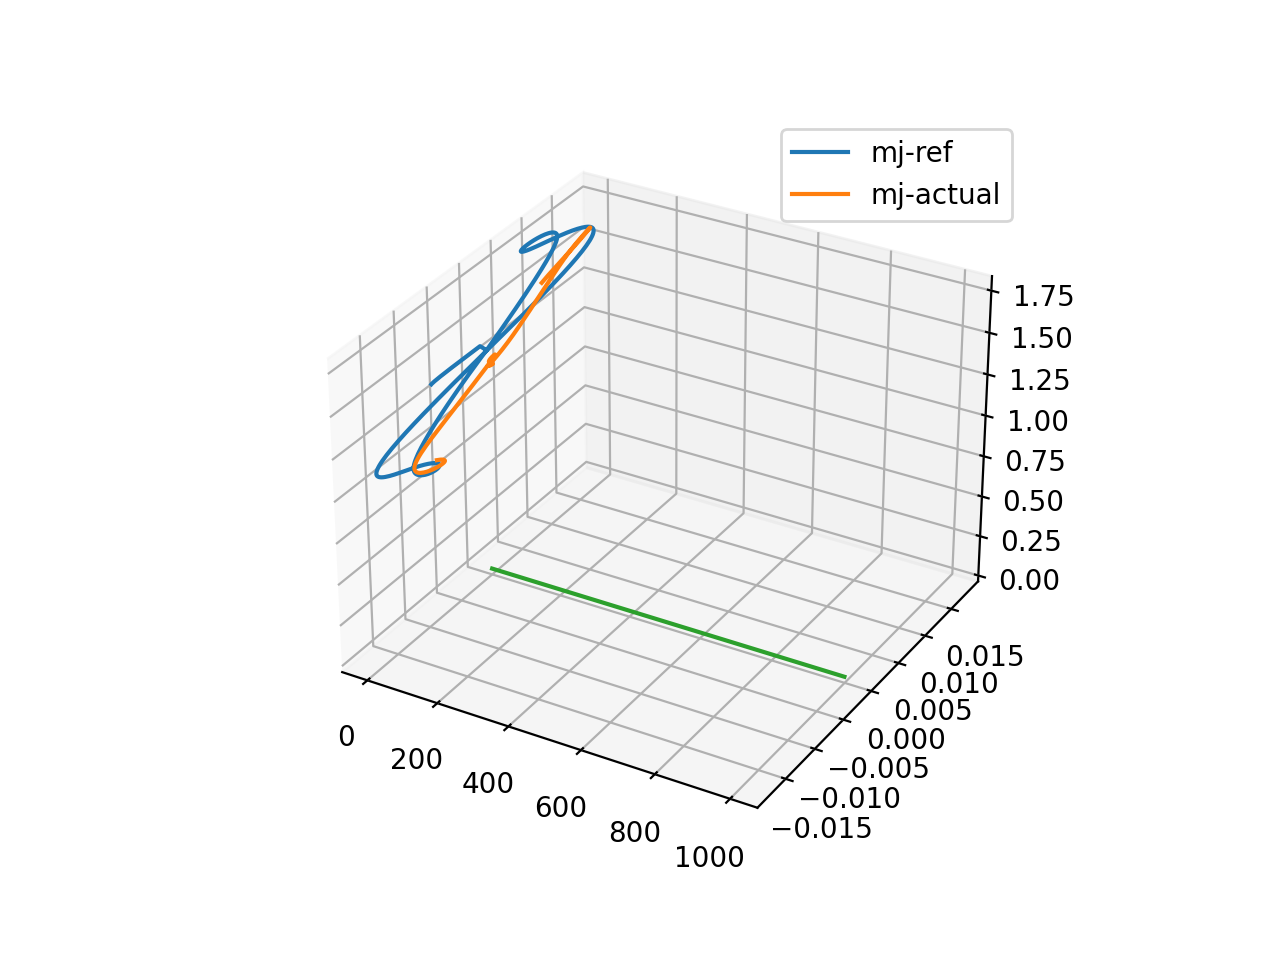

[2881, 3398, 3922, 4429, 4955, 5480, 6010, 6507, 7041, 7536, 8031, 8548, 9065, 9586, 10106, 10625, 11150, 11667, 12191, 12698, 13237, 13644, 14049, 14454, 14859, 15265, 15671, 16077, 16483, 16888, 17293, 17699, 18104, 18510, 18915, 19321, 19726, 20131, 20537, 20943, 21393, 21873, 22337, 22800, 23253, 23724, 24189, 24643, 25092, 25565, 26024, 26492, 26957, 27385, 27840, 28299, 28758, 29203, 29668, 30126, 30621, 31026, 31431, 31836, 32241, 32647, 33052, 33459, 33865, 34271, 34677, 35083, 35488, 35893, 36298, 36704, 37110, 37518, 37923, 38328, 38762, 39188, 39621, 40056, 40493, 40931, 41375, 41813, 42234, 42654, 43075, 43505, 43943, 44373, 44803, 45220, 45640, 46061, 46498, 46926]
[3181, 3698, 4222, 4729, 5255, 5780, 6310, 6807, 7341, 7836, 8331, 8848, 9365, 9886, 10406, 10925, 11450, 11967, 12491, 12998, 13537, 13944, 14349, 14754, 15159, 15565, 15971, 16377, 16783, 17188, 17593, 17999, 18404, 18810, 19215, 19621, 20026, 20431, 20837, 21243, 21693, 22173, 22637, 23100, 23553, 24024, 2448

In [49]:
# Visualize bag data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')

stmj = times[0::2]
etmj = times[1::2]

#st = times1[0::2]
#et = times1[1::2]

print(stmj)
print(etmj)

i = 12

axes.plot3D(ref_traj[stmj[i]-50:etmj[i]+50, 0], ref_traj[stmj[i]-50:etmj[i]+50, 1], ref_traj[stmj[i]-50:etmj[i]+50, 2], label='mj-ref')
axes.plot3D(actual_traj[stmj[i]-50:etmj[i]+50, 0], actual_traj[stmj[i]-50:etmj[i]+50, 1], actual_traj[stmj[i]-50:etmj[i]+50, 2], label='mj-actual')

#axes.plot3D(ref_traj1[st[i]:et[i], 0], ref_traj1[st[i]:et[i], 1], ref_traj1[st[i]:et[i], 2], label='nn-ref')
#axes.plot3D(actual_traj1[st[i]:et[i], 0], actual_traj1[st[i]:et[i], 1], actual_traj1[st[i]:et[i], 2], label='nn-actual')
plt.legend()

## Compute total tracking cost

15302
14927


<IPython.core.display.Javascript object>


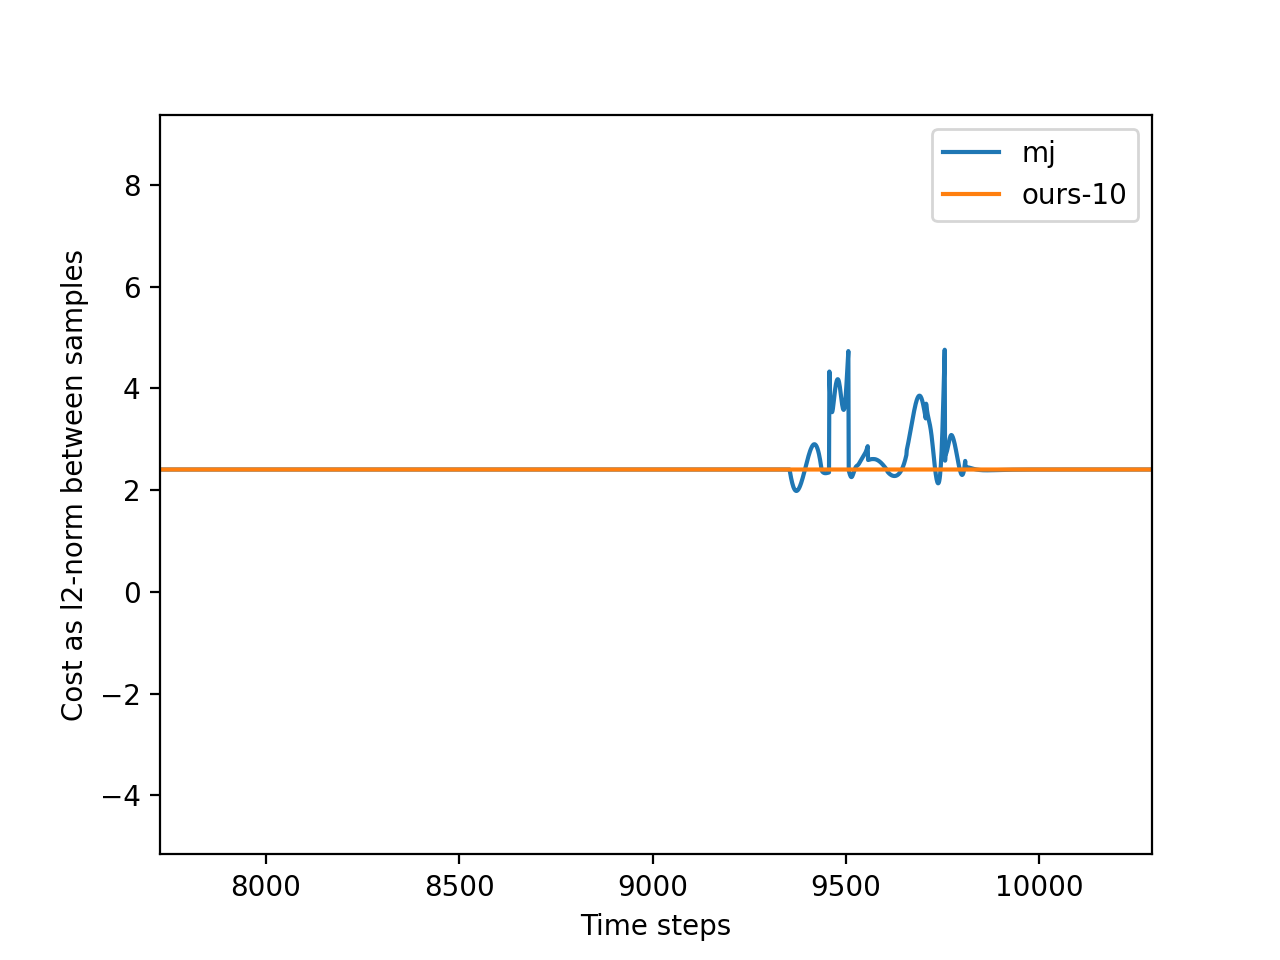

Text(0, 0.5, 'Cost as l2-norm between samples')

In [145]:
Tstart = 0
Tend = len(costmj)
print(len(costnn))
print(len(costmj))
plt.figure()
#plt.plot(range(Tstart, Tend), cost_traj.ravel()[Tstart:Tend])
plt.plot(range(Tstart, Tend), costmj[Tstart:Tend], label='mj')
plt.plot(range(Tstart, Tend), costnn[Tstart:Tend], label='ours-10')
# plt.plot(range(Tstart, Tend), np.cumsum(cost2.ravel()[Tstart:Tend]), label='ours-1')
# t.plot(range(Tstart, Tend), np.cumsum(cost3.ravel()[Tstart:Tend]), label='mk')
plt.legend()
plt.xlabel("Time steps")
plt.ylabel("Cost as l2-norm between samples")

# Inference on networks by computing cost only between start and end of trajectories

In [13]:
# Load bag with Lissajous curves
bag1 = load_bag('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/rho_lissajous0.bag')
ref_traj, actual_traj, input_traj, cost_traj, times = compute_traj(bag1, 
        '/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/rho_times0.pkl', False)
bag1.close()
print(times)

Ref traj shape (81474, 14)
Act traj shape (81474, 14)
[3079, 3379, 6316, 6616, 9480, 9780, 12814, 13114, 17427, 17727, 22054, 22354, 25776, 26076, 29982, 30282, 34122, 34422, 38232, 38532, 41988, 42288, 46437, 46737, 50256, 50556, 53850, 54150, 58951, 59251, 64029, 64329, 68024, 68324, 72384, 72684, 76723, 77023, 80565, 80865]


<IPython.core.display.Javascript object>


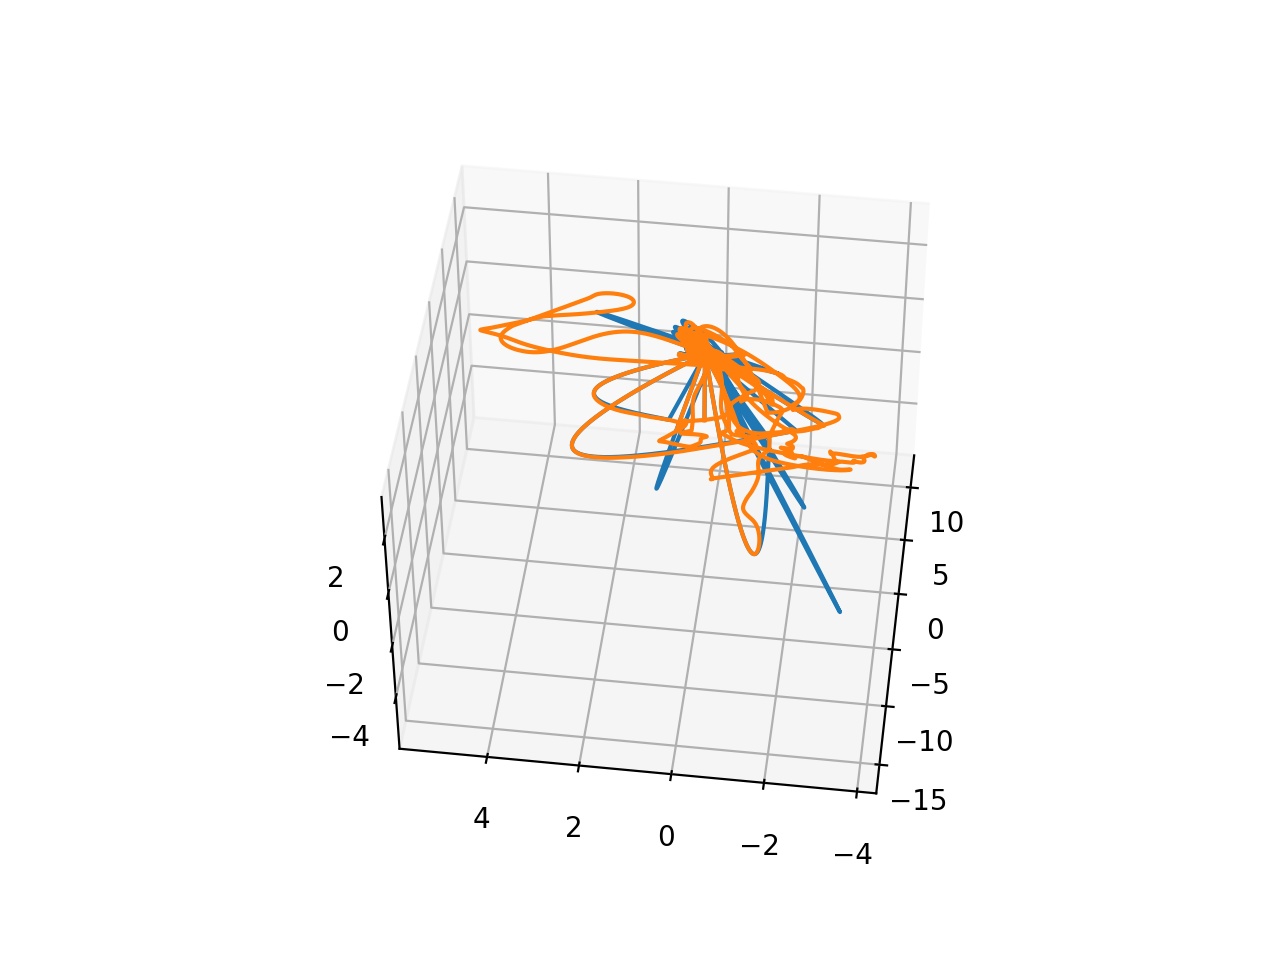

In [24]:
# Visualize bag data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')

Tstart1 = 0
Tend1 = -1

Tstart2 = 0
Tend2 = -1

axes.plot3D(ref_traj[Tstart1:Tend1, 0], ref_traj[Tstart1:Tend1, 1], ref_traj[Tstart1:Tend1, 2], label='mj-ref')
axes.plot3D(actual_traj[Tstart2:Tend2, 0], actual_traj[Tstart2:Tend2, 1], actual_traj[Tstart2:Tend2, 2], label='mj-actual')


In [25]:
# Load bag with Lissajous curves
bag2 = load_bag('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/rho_lissajous5.bag')
ref_traj1, actual_traj1, input_traj1, cost_traj1, times1 = compute_traj(bag2, 
        '/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/rho_times5.pkl', False)
bag1.close()
print(times1)

Ref traj shape (81464, 14)
Act traj shape (81464, 14)
[3488, 3788, 7360, 7660, 11031, 11331, 14770, 15070, 18918, 19218, 23668, 23968, 27302, 27602, 31260, 31560, 34999, 35299, 39349, 39649, 43184, 43484, 47448, 47748, 51379, 51679, 55117, 55417, 59816, 60116, 64296, 64596, 68175, 68475, 72397, 72697, 76827, 77127, 80478, 80778]


In [37]:
# Load bag with Lissajous curves
bag2 = load_bag('/home/anusha/Research/ws_kr/src/multi_mav_manager/kr_multi_mav_manager/scripts/.bag')
ref_traj2, actual_traj2, input_traj2, cost_traj2, times2 = compute_traj(bag2, 
        '/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/nn1_rho2_times.pkl', False)
bag1.close()
print(times2)

Ref traj shape (73917, 14)
Act traj shape (73917, 14)
[3064, 3364, 6188, 6488, 9642, 9942, 13056, 13356, 16574, 16874, 20552, 20852, 23964, 24264, 27315, 27615, 30731, 31031, 34692, 34992, 38112, 38412, 42415, 42715, 45892, 46192, 49205, 49505, 53009, 53309, 57301, 57601, 60730, 61030, 64252, 64552, 68368, 68668, 71655, 71955]


In [24]:
xcost = np.linalg.norm(actual_traj[:,(0,1,2)] - ref_traj[:,(0,1,2)], axis=1)**2 
ucost = 0.1 * np.linalg.norm(input_traj, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj[:, 12] - ref_traj[:, 12])
ra = np.abs(actual_traj[:, 12] + 2*np.pi-ref_traj[:,12])
yawcost = np.minimum(ar, ra) ** 2
cost = xcost + yawcost + ucost

In [12]:
%matplotlib notebook

91015


<IPython.core.display.Javascript object>


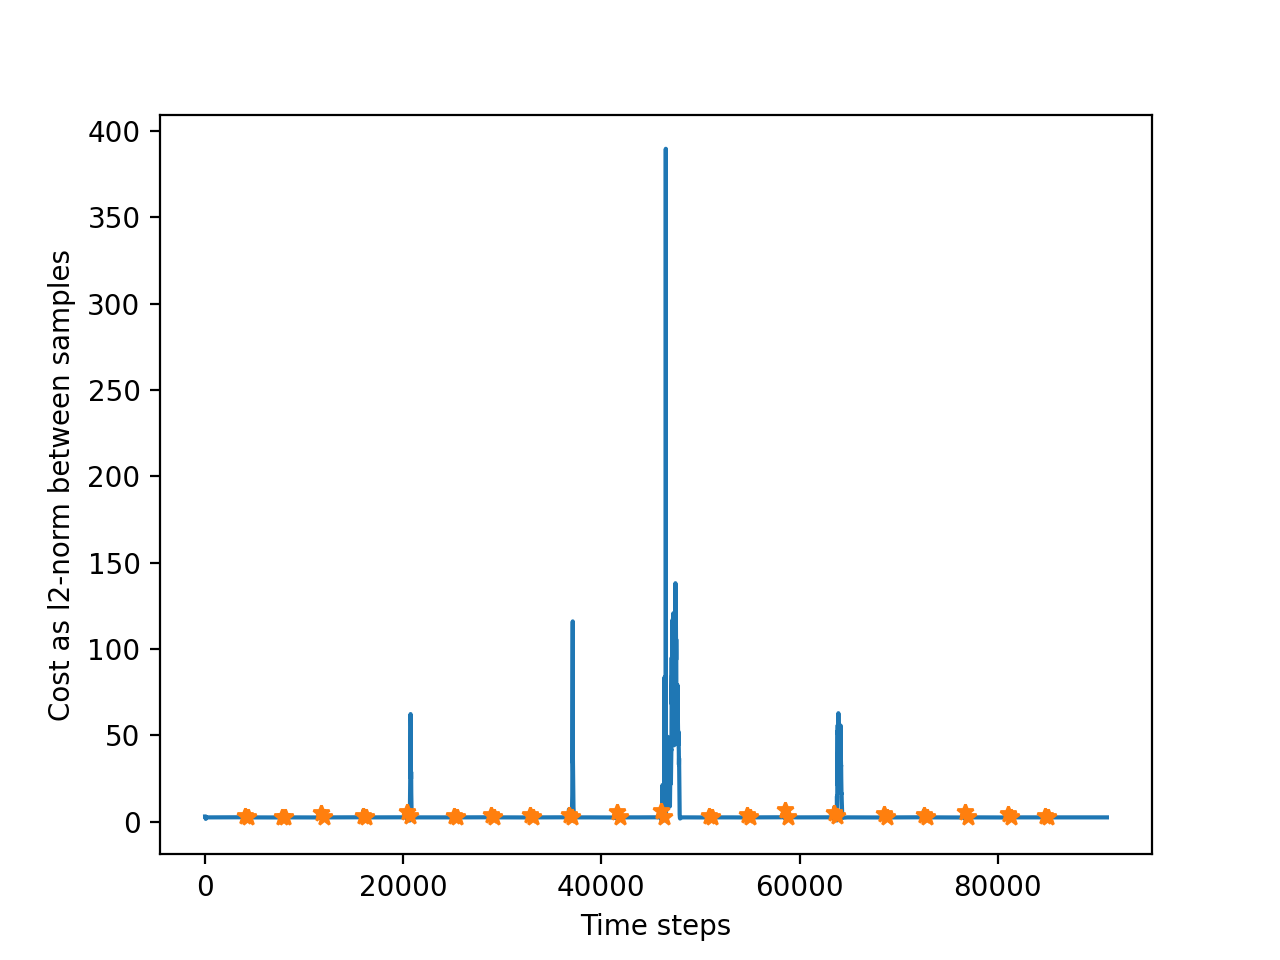

Text(0, 0.5, 'Cost as l2-norm between samples')

In [25]:
Tstart = 0
Tend = cost.shape[0]
print(Tend)
plt.figure()
plt.plot(range(Tstart, Tend), cost.ravel()[Tstart:Tend])
plt.plot(times, cost[times], '*')
plt.xlabel("Time steps")
plt.ylabel("Cost as l2-norm between samples")

In [26]:
xcost1 = np.linalg.norm(actual_traj1[:,(0,1,2)] - ref_traj1[:,(0,1,2)], axis=1)**2 
ucost1 = 0.1 * np.linalg.norm(input_traj1, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj1[:, 12] - ref_traj1[:, 12])
ra = np.abs(actual_traj1[:, 12] + 2*np.pi-ref_traj1[:,12])
yawcost1 = np.minimum(ar, ra) ** 2
cost1 = xcost1 + yawcost1 + ucost1

101733


<IPython.core.display.Javascript object>


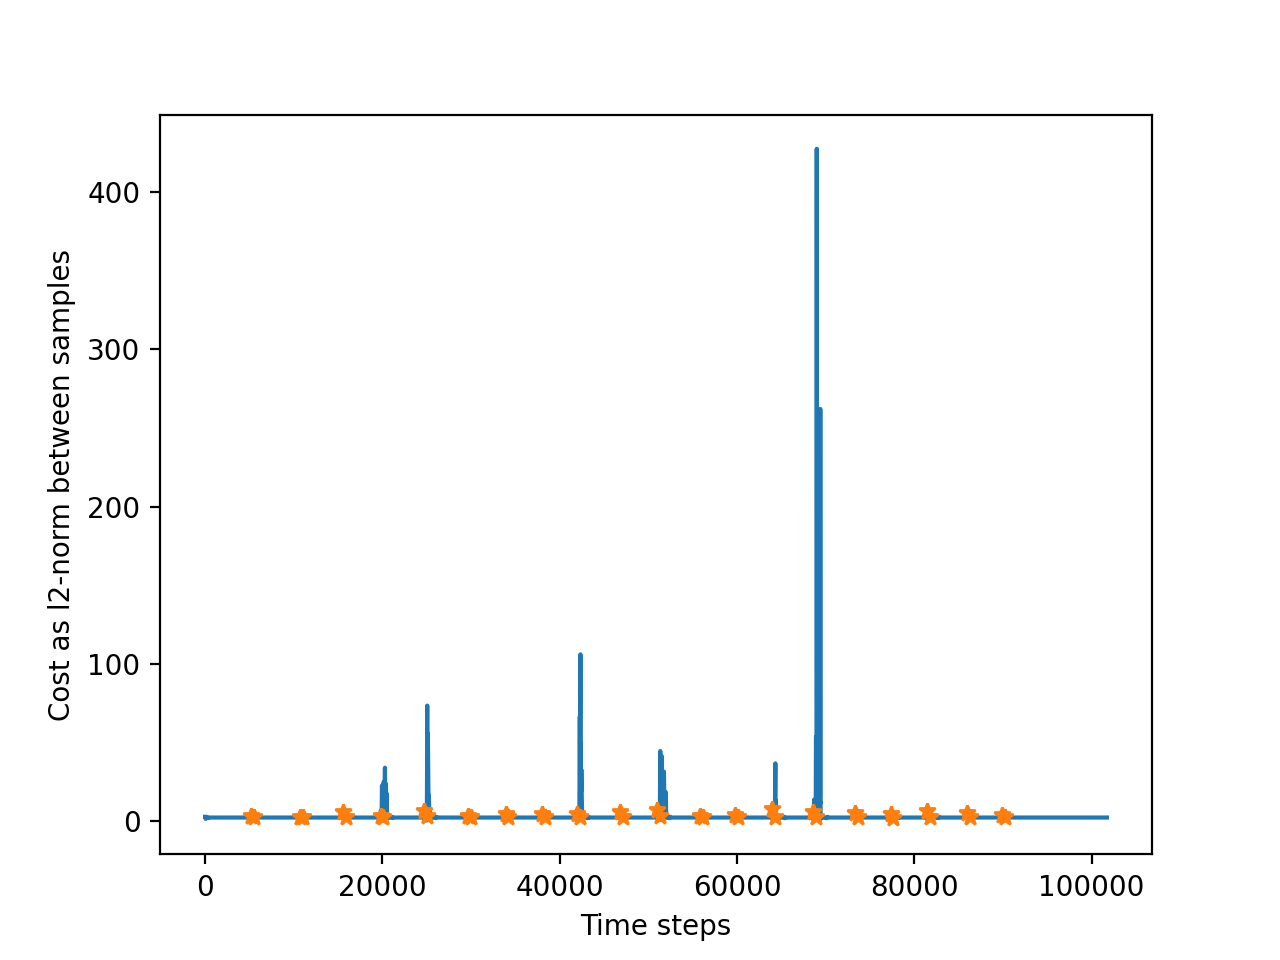

Text(0, 0.5, 'Cost as l2-norm between samples')

In [27]:
Tstart = 0
Tend = cost1.shape[0]
print(Tend)
plt.figure()
plt.plot(range(Tstart, Tend), cost1.ravel()[Tstart:Tend])
plt.plot(times1, cost_traj1[times1], '*')
plt.xlabel("Time steps")
plt.ylabel("Cost as l2-norm between samples")

In [38]:
xcost2 = np.linalg.norm(actual_traj2[:,(0,1,2)] - ref_traj2[:,(0,1,2)], axis=1)**2 
ucost2 = 0.1 * np.linalg.norm(input_traj2, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj2[:, 12] - ref_traj2[:, 12])
ra = np.abs(actual_traj2[:, 12] + 2*np.pi-ref_traj2[:,12])
yawcost2 = np.minimum(ar, ra) ** 2
cost2 = xcost2 + yawcost2 + ucost2

73917


Text(0, 0.5, 'Cost as l2-norm between samples')

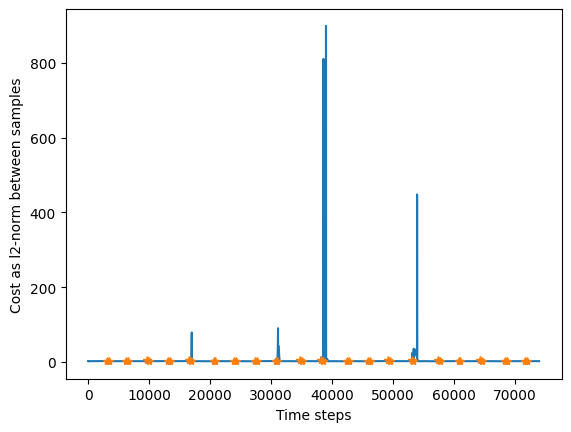

In [39]:
Tstart = 0
Tend = cost2.shape[0]
print(Tend)
plt.figure()
plt.plot(range(Tstart, Tend), cost2.ravel()[Tstart:Tend])
plt.plot(times2, cost_traj2[times2], '*')
plt.xlabel("Time steps")
plt.ylabel("Cost as l2-norm between samples")

In [28]:
# Compute tracking cost

# print(end)
def compute_cost(start, end, cost):
    total_cost = []
    for i in range(len(start)):
        total_cost = np.append(total_cost, sum(cost[start[i]:end[i]]))
    return total_cost

def compute_utility(start, end, inp):
    total_util = []
    for i in range(len(start)):
        total_util = np.append(total_util, sum(inp[start[i]:end[i]]))
    return total_util

932.8460565318053
5.438963662450364
9.227125974981762
1016.7900381149636


<IPython.core.display.Javascript object>


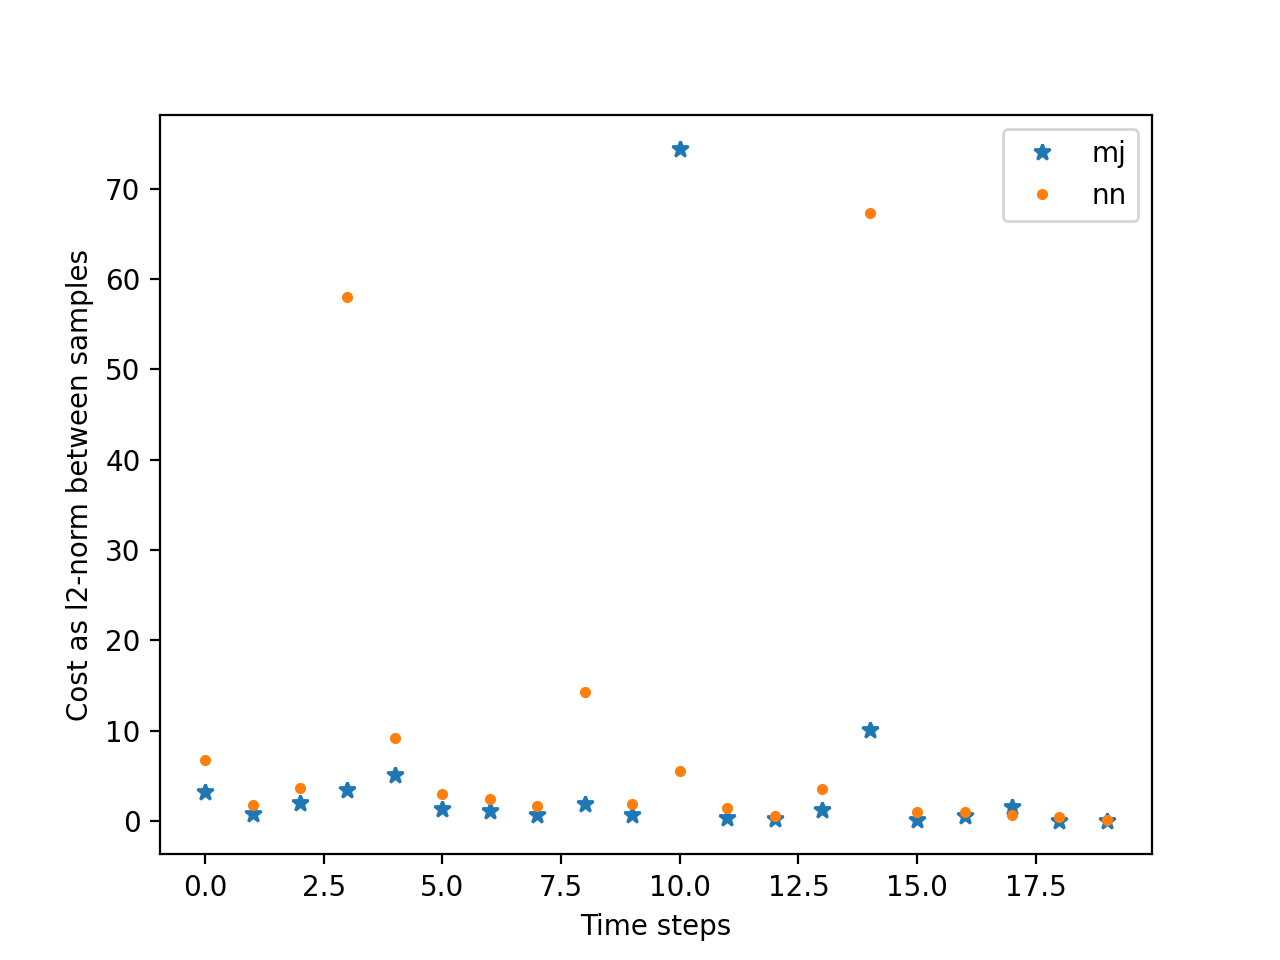

Text(0, 0.5, 'Cost as l2-norm between samples')

In [29]:
        
st = times[0::2]
et = times[1::2]

tc = compute_cost(st, et, xcost)
uc = compute_utility(st, et, ucost)
print(np.mean(uc))
print(np.mean(tc))


st = times1[0::2]
et = times1[1::2]
tc1 = compute_cost(st, et, xcost1)
print(np.mean(tc1))
#print(sum(tc1))
uc1 = compute_utility(st, et, ucost1)
print(np.mean(uc1))


"""st = times2[0::2]
et = times2[1::2]
tc2 = compute_cost(st, et, cost2)
uc2 = compute_utility(st, et, input_traj2)


print(st1)
print(et1)
st1 = times1[0::2]
et1 = times1[1::2]
print(st1)
print(et1)
tc1 = compute_cost(st1, et1, cost1)
print(len(tc1))"""

#print(start)


plt.figure()
plt.plot(range(0, len(tc)), tc, '*', label='mj')
plt.plot(range(0, len(tc1)), tc1, '.', label='nn')
#plt.plot(range(0, len(tc2)), tc2, 'r*', label='nn2')
plt.plot()
# plt.plot(range(Tstart, Tend), np.cumsum(cost2.ravel()[Tstart:Tend]), label='ours-1')
# t.plot(range(Tstart, Tend), np.cumsum(cost3.ravel()[Tstart:Tend]), label='mk')
plt.legend()
plt.xlabel("Time steps")
plt.ylabel("Cost as l2-norm between samples")

[3488, 3788, 7360, 7660, 11031, 11331, 14770, 15070, 18918, 19218, 23668, 23968, 27302, 27602, 31260, 31560, 34999, 35299, 39349, 39649, 43184, 43484, 47448, 47748, 51379, 51679, 55117, 55417, 59816, 60116, 64296, 64596, 68175, 68475, 72397, 72697, 76827, 77127, 80478, 80778]
20


<IPython.core.display.Javascript object>


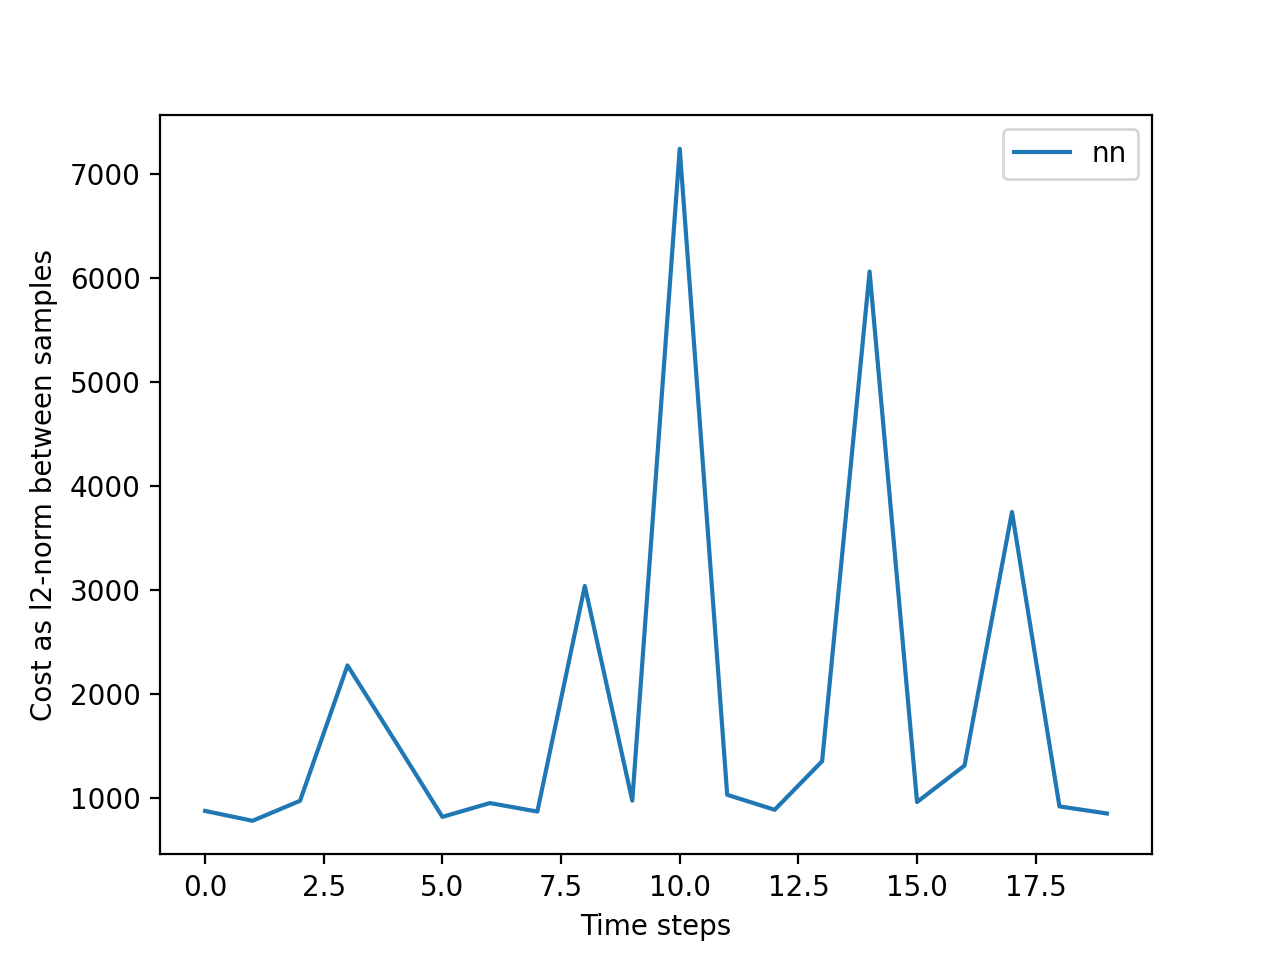

Text(0, 0.5, 'Cost as l2-norm between samples')

In [26]:
# Compute tracking cost

print(times1)
def compute_cost(start, end, cost):
    total_cost = []
    for i in range(len(start)):
        total_cost = np.append(total_cost, sum(cost[st[i]:et[i]]))
    return total_cost
        
st = times1[0::2]
et = times1[1::2]
tc1 = compute_cost(st, et, cost1)
print(len(tc1))


plt.figure()
plt.plot(range(0, len(tc1)), tc1, label='nn')
plt.plot()
# plt.plot(range(Tstart, Tend), np.cumsum(cost2.ravel()[Tstart:Tend]), label='ours-1')
# t.plot(range(Tstart, Tend), np.cumsum(cost3.ravel()[Tstart:Tend]), label='mk')
plt.legend()
plt.xlabel("Time steps")
plt.ylabel("Cost as l2-norm between samples")

[3326, 3626, 9765, 10065, 13237, 13537, 17200, 17500, 23149, 23449, 29917, 30217, 34571, 34871, 41260, 41560, 57210, 57510, 63205, 63505, 69566, 69866, 75309, 75609, 82600, 82900, 88288, 88588, 93014, 93314, 98003, 98303, 103209, 103509, 108416, 108716, 113556, 113856, 118272, 118572]
20


Text(0, 0.5, 'Cost as l2-norm between samples')

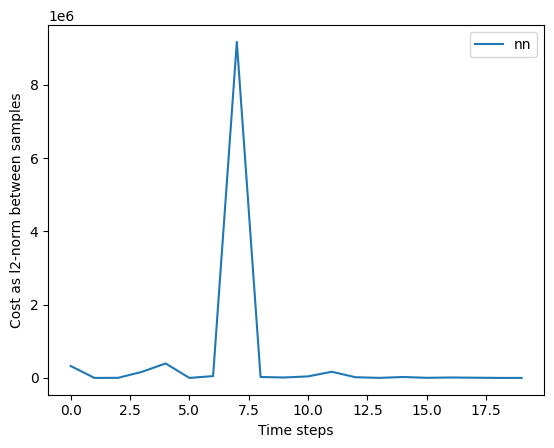

In [14]:
# Compute tracking cost

print(times2)
def compute_cost(start, end, cost):
    total_cost = []
    for i in range(len(start)):
        total_cost = np.append(total_cost, sum(cost[st[i]:et[i]]))
    return total_cost
        
st = times2[0::2]
et = times2[1::2]
tc2 = compute_cost(st, et, cost2)
print(len(tc1))


plt.figure()
plt.plot(range(0, len(tc2)), tc2, label='nn')
plt.plot()
# plt.plot(range(Tstart, Tend), np.cumsum(cost2.ravel()[Tstart:Tend]), label='ours-1')
# t.plot(range(Tstart, Tend), np.cumsum(cost3.ravel()[Tstart:Tend]), label='mk')
plt.legend()
plt.xlabel("Time steps")
plt.ylabel("Cost as l2-norm between samples")

## Load trajectories for hardware experiments

In [26]:
# Load bag with Lissajous curves for min jerk
bag1 = load_bag('/home/anusha/Research/ws_kr/src/multi_mav_manager/kr_multi_mav_manager/scripts/mj_lissajous_0.bag')
ref_traj, actual_traj, input_traj, cost_traj, times = compute_traj(bag1, 
        '/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/mj0_times.pkl', False)
bag1.close()
print(times)

Ref traj shape (81474, 14)
Act traj shape (81474, 14)
[]


In [27]:
# Load bag with Lissajous curves for mlp
bag2 = load_bag('/home/anusha/Research/ws_kr/src/multi_mav_manager/kr_multi_mav_manager/scripts/rho5_lissajous.bag')
ref_traj1, actual_traj1, input_traj1, cost_traj1, times1 = compute_traj(bag2, 
        '/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/rho5_times.pkl', False)
bag1.close()
print(times1)

Ref traj shape (101415, 14)
Act traj shape (101415, 14)
[]


In [22]:
# Reference trajectories to be saved for running on hardware

def get_traj(start, end, traj, traj_idx):
    full_traj = []
    for i in traj_idx:
        full_traj.append(traj[start[i]:end[i], :])
    return full_traj

In [23]:
stmj = times[0::2]
etmj = times[1::2]

stmlp = times1[0::2]
etmlp = times1[1::2]

traj_idx = [0, 1, 2, 5, 7, 18, 19]

f_traj = get_traj(stmj, etmj, ref_traj, traj_idx)
f_traj1 = get_traj(stmlp, etmlp, ref_traj1, traj_idx)

print(f_traj[3][0:20, 2])
print(f_traj1[3][0:20, 2])

for i in range(len(traj_idx)):
    f_traj[i][:, 2] -= 1
    
print(f_traj[3][0:20, 2])

import pickle

# Save list to a pickle file
with open('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/mj_hardware.pickle', 'wb') as handle:
    pickle.dump(f_traj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/home/anusha/Research/ws_kr/src/layered_ref_control/src/layered_ref_control/data/mlp_hardware.pickle', 'wb') as handle:
    pickle.dump(f_traj1, handle, protocol=pickle.HIGHEST_PROTOCOL)

[2.03060284 2.03060889 2.03062489 2.03065523 2.03070387 2.03077441
 2.03087008 2.03099374 2.0311479  2.03133473 2.03155607 2.03181346
 2.03210813 2.032441   2.03281274 2.03322373 2.03367408 2.0341637
 2.03469222 2.03525907]
[1.03060273 1.03060805 1.03062218 1.03064906 1.03069234 1.03075536
 1.03084118 1.03095257 1.03109202 1.03126175 1.03146371 1.0316996
 1.03197083 1.03227861 1.03262388 1.03300735 1.0334295  1.03389059
 1.03439064 1.0349295 ]
[1.03060284 1.03060889 1.03062489 1.03065523 1.03070387 1.03077441
 1.03087008 1.03099374 1.0311479  1.03133473 1.03155607 1.03181346
 1.03210813 1.032441   1.03281274 1.03322373 1.03367408 1.0341637
 1.03469222 1.03525907]


## Processing the data bags from hardware experiments

In [2]:
from construct_traj_hardware import *
import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt
import torch

from learning import lstd, valuefunc, trajdata
from env import linearenv, controller
from exputils import relerr
from trajgen import quadratic, nonlinear

/home/anusha/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load bag with Lissajous curves for min jerk
bag1 = load_bag('/home/anusha/Downloads/hardware_exp/exp2/mlp_2022-09-15-19-14-31.bag')
ref_traj, actual_traj, input_traj = compute_traj(bag1, False)
bag1.close()

Ref traj shape (9599, 14)
Act traj shape (8637, 14)


In [4]:
%matplotlib notebook

<IPython.core.display.Javascript object>


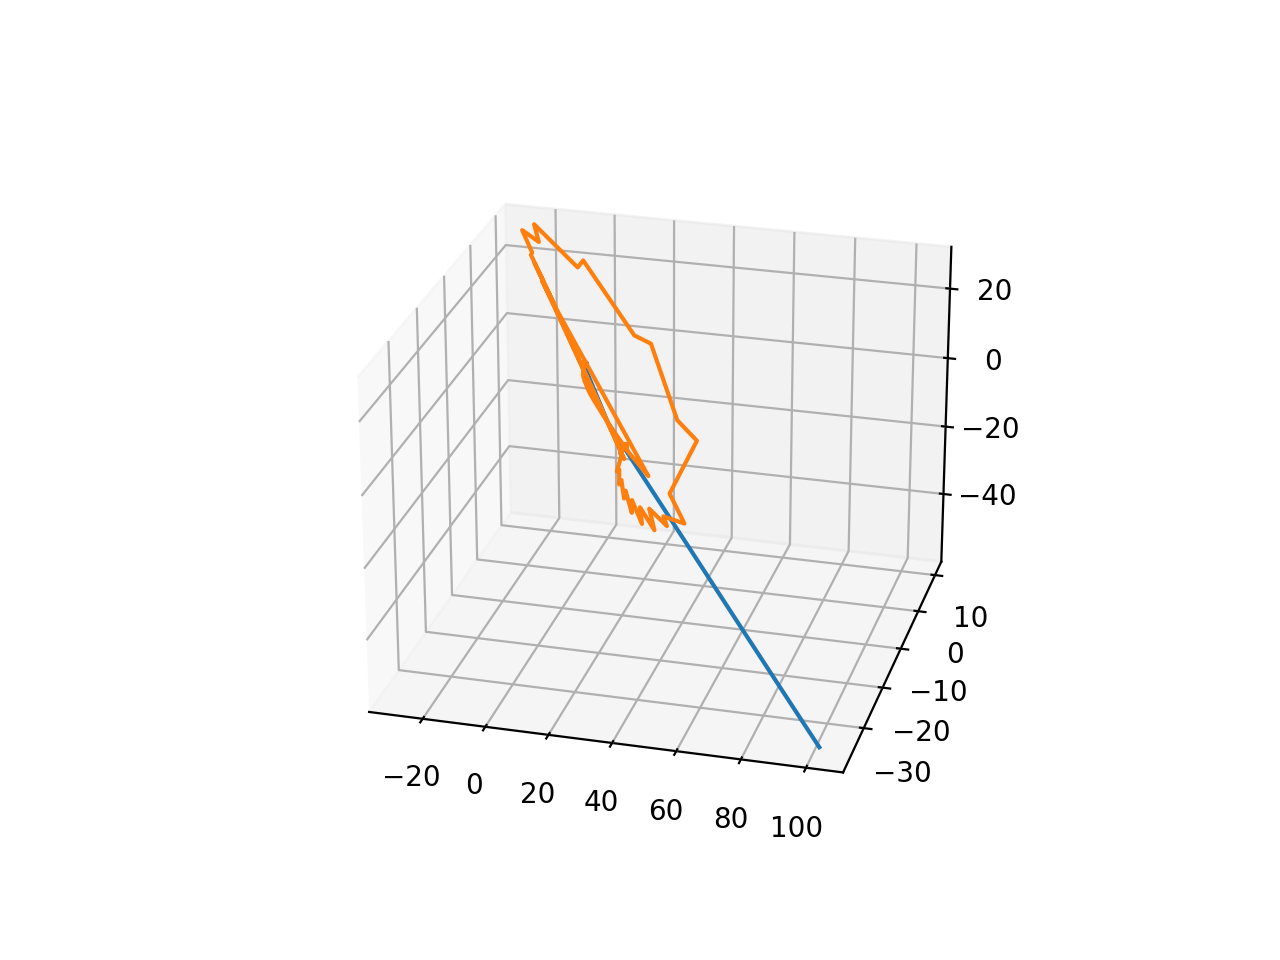

In [7]:
# Visualize bag data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')

Tstart1 = 0
Tend1 = ref_traj.shape[0] 

Tstart2 = 0
Tend2 = actual_traj.shape[0]

axes.plot3D(ref_traj[Tstart1:Tend1, 0], ref_traj[Tstart1:Tend1, 1], ref_traj[Tstart1:Tend1, 2], label='mj-ref')
axes.plot3D(actual_traj[Tstart2:Tend2, 0], actual_traj[Tstart2:Tend2, 1], actual_traj[Tstart2:Tend2, 2], label='mj-actual')


In [16]:
# Load bag with Lissajous curves for min jerk
bag1 = load_bag('/home/anusha/Downloads/hardware_exp/exp1/mlp_2022-09-14-22-50-09.bag')
ref_traj1, actual_traj1, input_traj1 = compute_traj(bag1, False)
bag1.close()

Ref traj shape (14981, 14)
Act traj shape (22202, 14)


<IPython.core.display.Javascript object>


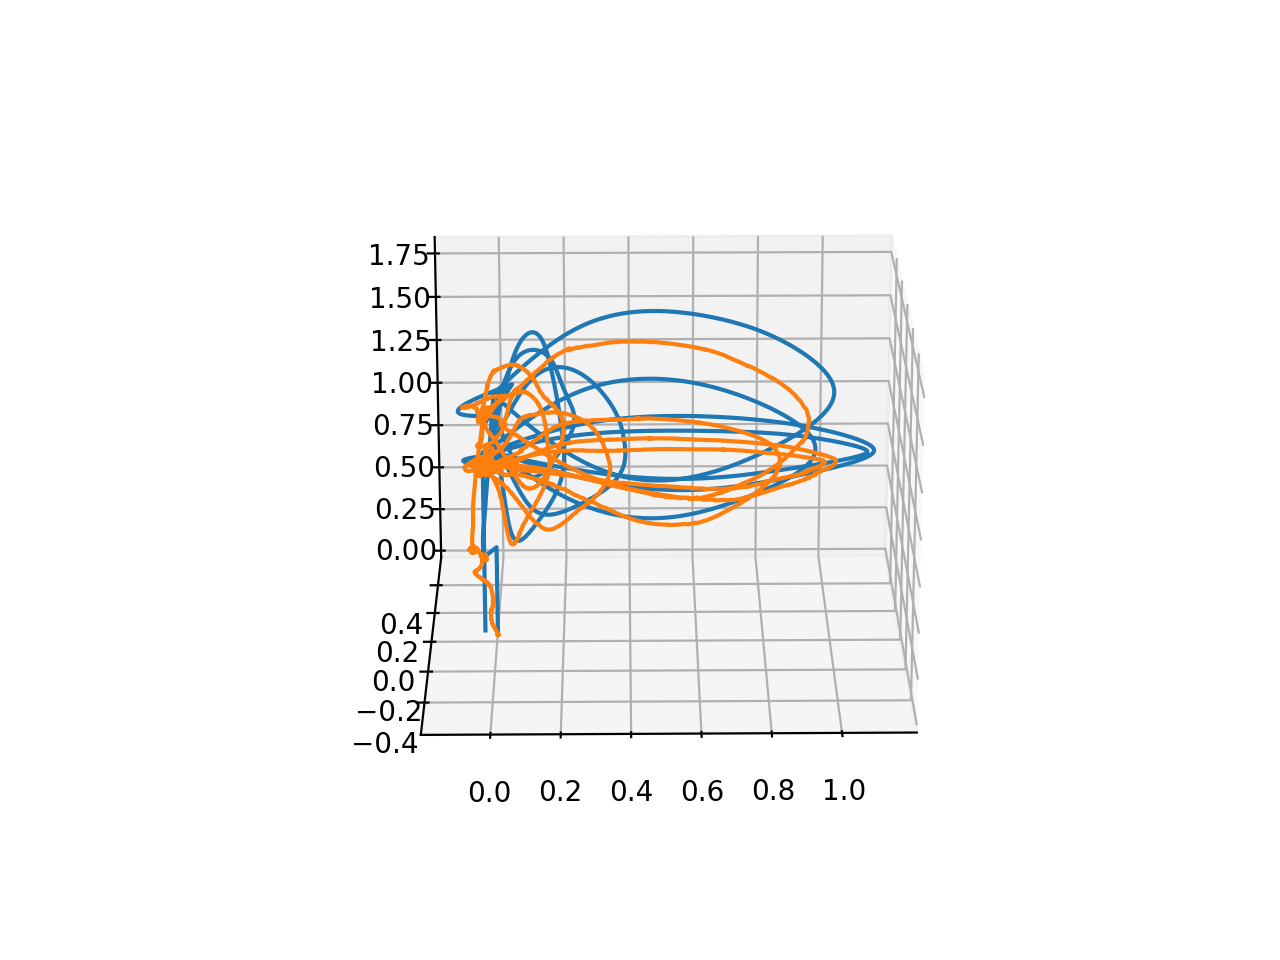

In [24]:
# Visualize bag data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')

Tstart = 0
Tend = ref_traj1.shape[0]

Tstart1 = 0
Tend1 = actual_traj1.shape[0] - 1800

axes.plot3D(ref_traj1[Tstart:Tend, 0], ref_traj1[Tstart:Tend, 1], ref_traj1[Tstart:Tend, 2], label='mlp-ref')
axes.plot3D(actual_traj1[Tstart1:Tend1, 0], actual_traj1[Tstart1:Tend1, 1], actual_traj1[Tstart1:Tend1, 2], label='mlp-actual')


<IPython.core.display.Javascript object>


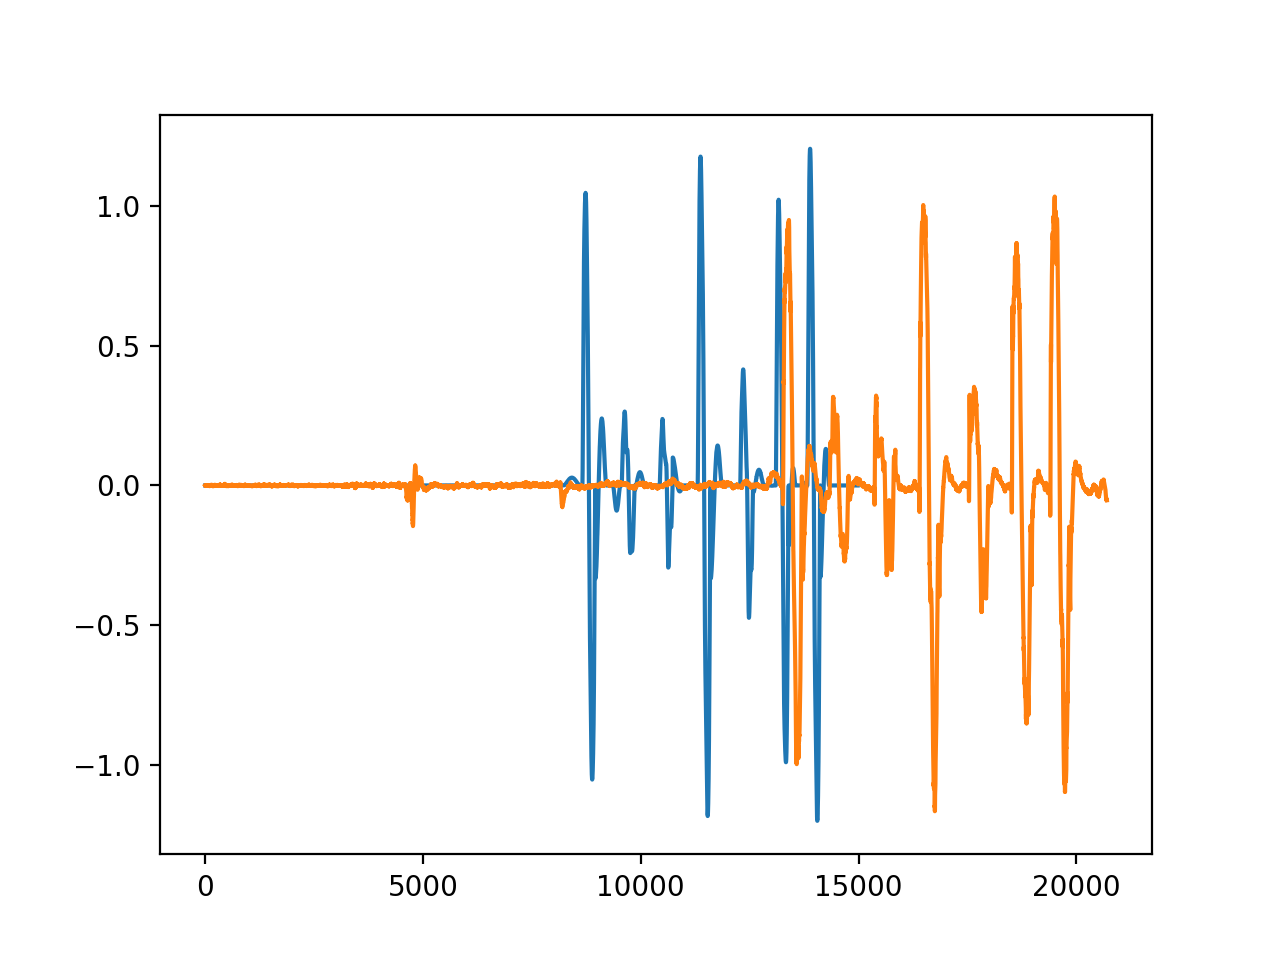

13481


In [45]:
plt.figure()
print(len(ref_traj1[:-1500, 3]))
plt.plot(ref_traj1[:, 3])
plt.plot(actual_traj1[:-1500, 3])


In [69]:
# Load bag with Lissajous curves for min jerk
bag1 = load_bag('/home/anusha/Downloads/hardware_exp/exp1/kr_2022-09-14-23-05-52.bag')
ref_traj2, actual_traj2, input_traj2, cost_traj2 = compute_traj(bag1, False)
bag1.close()

Ref traj shape (12045, 14)
Act traj shape (12045, 14)
Input shape 12045


<IPython.core.display.Javascript object>


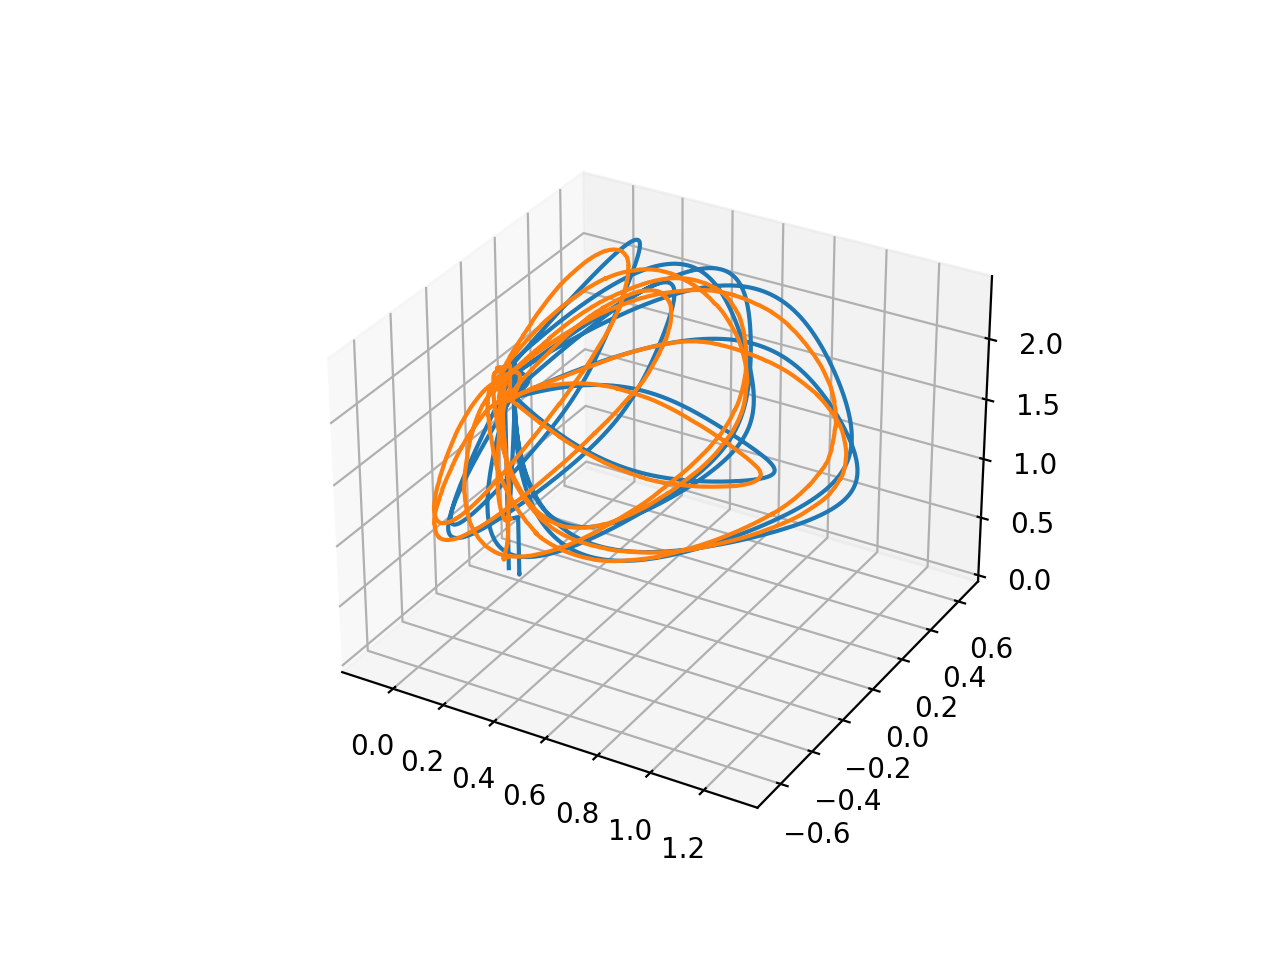

In [70]:
# Visualize bag data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')

Tstart = 0
Tend = ref_traj2.shape[0] 

axes.plot3D(ref_traj2[Tstart:Tend, 0], ref_traj2[Tstart:Tend, 1], ref_traj2[Tstart:Tend, 2], label='kr1-ref')
axes.plot3D(actual_traj2[Tstart:Tend, 0], actual_traj2[Tstart:Tend, 1], actual_traj2[Tstart:Tend, 2], label='kr1-actual')


In [71]:
# Load bag with Lissajous curves for min jerk
bag1 = load_bag('/home/anusha/Downloads/hardware_exp/exp1/kr_2022-09-14-23-11-42.bag')
ref_traj3, actual_traj3, input_traj3, cost_traj3 = compute_traj(bag1, False)
bag1.close()

Ref traj shape (10373, 14)
Act traj shape (10373, 14)
Input shape 10373


<IPython.core.display.Javascript object>


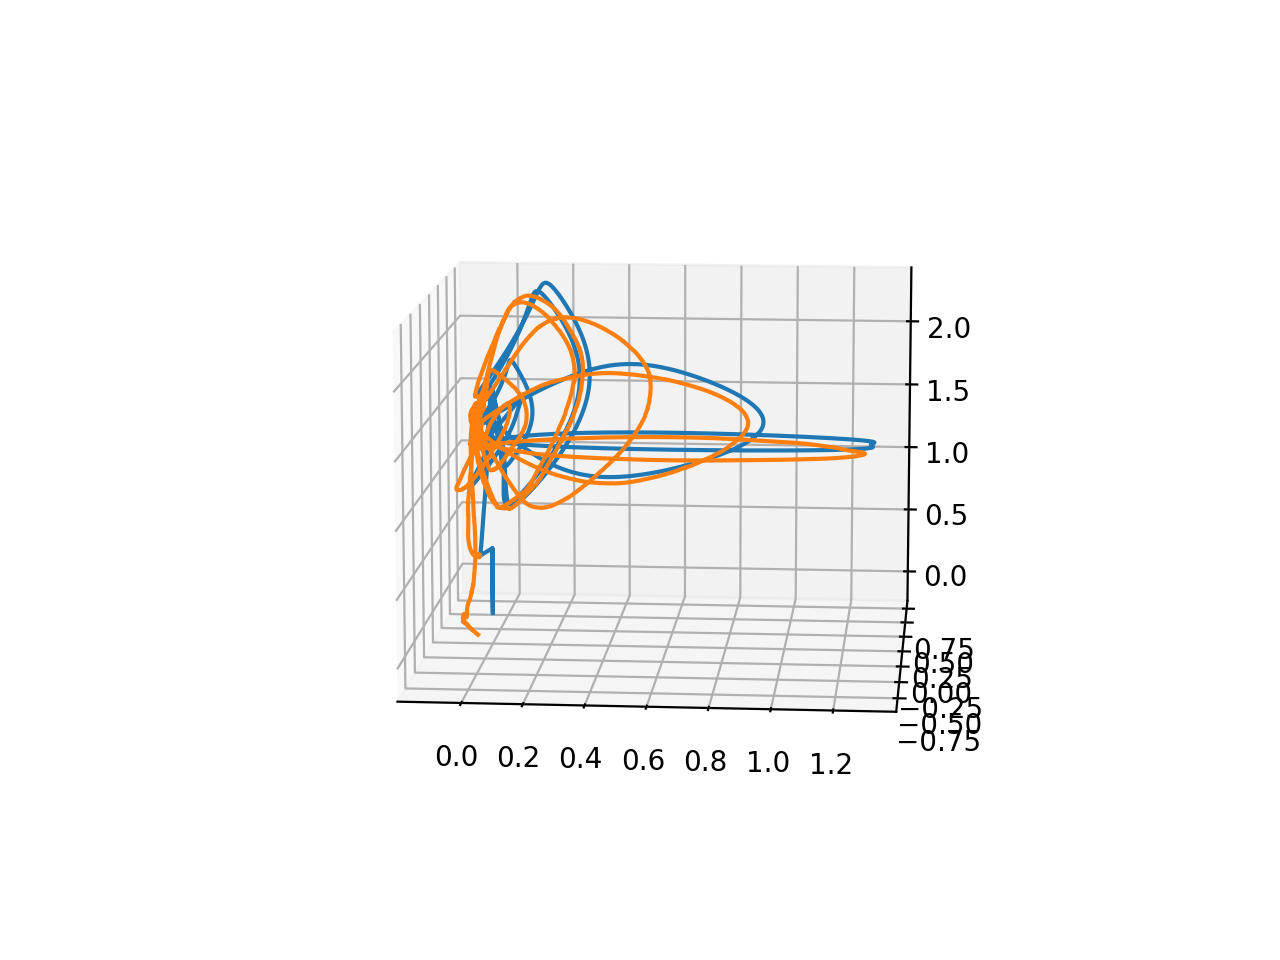

In [74]:
# Visualize bag data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')

Tstart = 0
Tend = ref_traj3.shape[0] - 1650

axes.plot3D(ref_traj3[Tstart:Tend, 0], ref_traj3[Tstart:Tend, 1], ref_traj3[Tstart:Tend, 2], label='kr2-ref')
axes.plot3D(actual_traj3[Tstart:Tend, 0], actual_traj3[Tstart:Tend, 1], actual_traj3[Tstart:Tend, 2], label='kr2-actual')


In [75]:
xcost = np.linalg.norm(actual_traj[:,(0,1,2)] - ref_traj[:,(0,1,2)], axis=1)**2 
ucost = 0.1 * np.linalg.norm(input_traj, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj[:, 12] - ref_traj[:, 12])
ra = np.abs(actual_traj[:, 12] + 2*np.pi-ref_traj[:,12])
yawcost = np.minimum(ar, ra) ** 2
cost = xcost + yawcost + ucost

In [76]:
xcost1 = np.linalg.norm(actual_traj1[:,(0,1,2)] - ref_traj1[:,(0,1,2)], axis=1)**2 
ucost1 = 0.1 * np.linalg.norm(input_traj1, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj1[:, 12] - ref_traj1[:, 12])
ra = np.abs(actual_traj1[:, 12] + 2*np.pi-ref_traj1[:,12])
yawcost1 = np.minimum(ar, ra) ** 2
cost1 = xcost1 + yawcost1 + ucost1

In [77]:
xcost2 = np.linalg.norm(actual_traj2[:,(0,1,2)] - ref_traj2[:,(0,1,2)], axis=1)**2 
ucost2 = 0.1 * np.linalg.norm(input_traj2, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj2[:, 12] - ref_traj2[:, 12])
ra = np.abs(actual_traj2[:, 12] + 2*np.pi-ref_traj2[:,12])
yawcost2 = np.minimum(ar, ra) ** 2
cost2 = xcost2 + yawcost2 + ucost2

In [78]:
xcost3 = np.linalg.norm(actual_traj3[:,(0,1,2)] - ref_traj3[:,(0,1,2)], axis=1)**2 
ucost3 = 0.1 * np.linalg.norm(input_traj3, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj3[:, 12] - ref_traj3[:, 12])
ra = np.abs(actual_traj3[:, 12] + 2*np.pi-ref_traj3[:,12])
yawcost3 = np.minimum(ar, ra) ** 2
cost3 = xcost3 + yawcost3 + ucost3

In [ ]:
print(np.mean())

In [79]:
def compute_cost(start, end, cost):
    total_cost = []
    for i in range(len(start)):
        total_cost = np.append(total_cost, sum(cost[start[i]:end[i]]))
    return total_cost

<IPython.core.display.Javascript object>


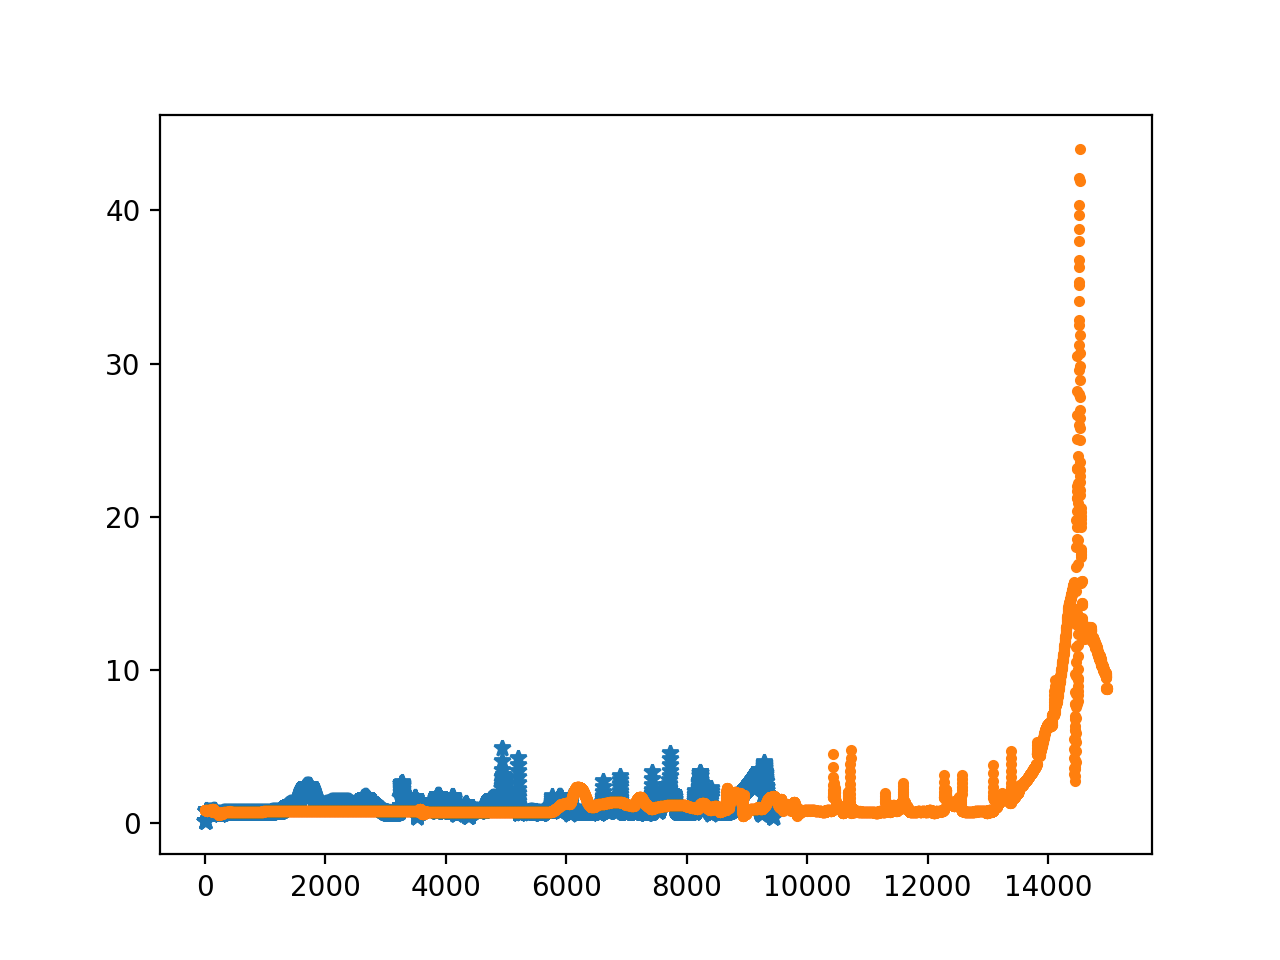

In [89]:
plt.figure()
plt.plot(range(0, len(cost)), cost, '*', label='mj')
plt.plot(range(0, len(cost1)), cost1, '.', label='nn')

## Gradient Inference

In [34]:
bag = load_bag('/home/anusha/Research/ws_kr/src/multi_mav_manager/kr_multi_mav_manager/scripts/fig2_old_5.bag')
#ref_traj, actual_traj, input_traj, cost_traj = compute_traj(bag, False)
ref_traj, actual_traj, input_traj, cost_traj, times = compute_traj(bag, '/home/anusha/Downloads/icra_results/fig2_old_5_times.pkl', False)

Ref traj shape (47964, 14)
Act traj shape (47964, 14)


In [35]:
print(times) 

[2881, 3181, 3398, 3698, 3922, 4222, 4429, 4729, 4955, 5255, 5480, 5780, 6010, 6310, 6507, 6807, 7041, 7341, 7536, 7836, 8031, 8331, 8548, 8848, 9065, 9365, 9586, 9886, 10106, 10406, 10625, 10925, 11150, 11450, 11667, 11967, 12191, 12491, 12698, 12998, 13237, 13537, 13644, 13944, 14049, 14349, 14454, 14754, 14859, 15159, 15265, 15565, 15671, 15971, 16077, 16377, 16483, 16783, 16888, 17188, 17293, 17593, 17699, 17999, 18104, 18404, 18510, 18810, 18915, 19215, 19321, 19621, 19726, 20026, 20131, 20431, 20537, 20837, 20943, 21243, 21393, 21693, 21873, 22173, 22337, 22637, 22800, 23100, 23253, 23553, 23724, 24024, 24189, 24489, 24643, 24943, 25092, 25392, 25565, 25865, 26024, 26324, 26492, 26792, 26957, 27257, 27385, 27685, 27840, 28140, 28299, 28599, 28758, 29058, 29203, 29503, 29668, 29968, 30126, 30426, 30621, 30921, 31026, 31326, 31431, 31731, 31836, 32136, 32241, 32541, 32647, 32947, 33052, 33352, 33459, 33759, 33865, 34165, 34271, 34571, 34677, 34977, 35083, 35383, 35488, 35788, 35893

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


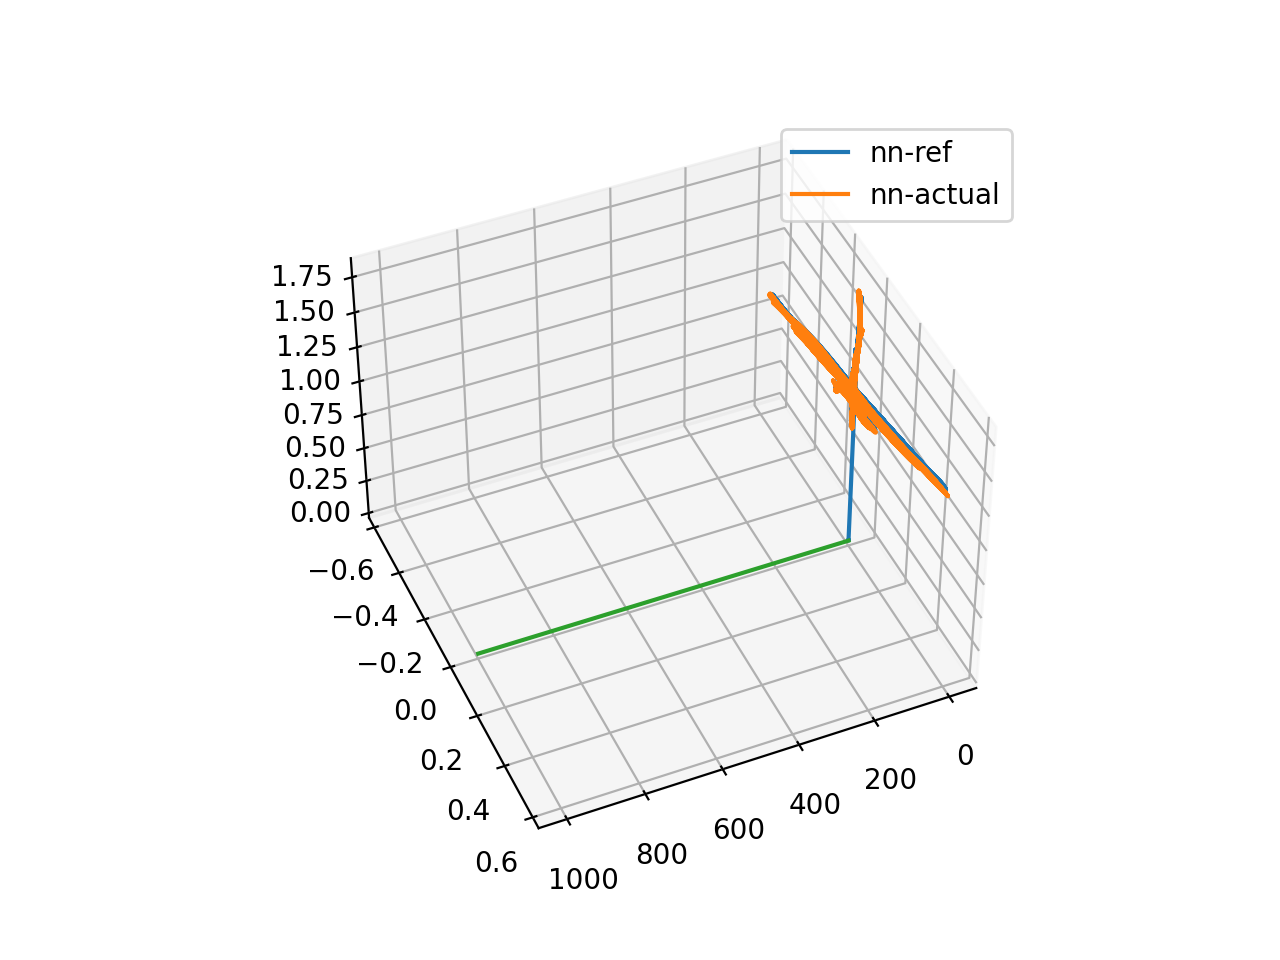

In [48]:
# Visualize bag data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
axes = fig.add_subplot(111, projection='3d')

ttt = 31
Tstart1 = 0
Tend1 = -1

Tstart2 = 0
Tend2 = -1

axes.plot3D(ref_traj[Tstart1:Tend1, 0], ref_traj[Tstart1:Tend1, 1], ref_traj[Tstart1:Tend1, 2], label='nn-ref')
axes.plot3D(actual_traj[Tstart2:Tend2, 0], actual_traj[Tstart2:Tend2, 1], actual_traj[Tstart2:Tend2, 2], label='nn-actual')
plt.legend()

<IPython.core.display.Javascript object>


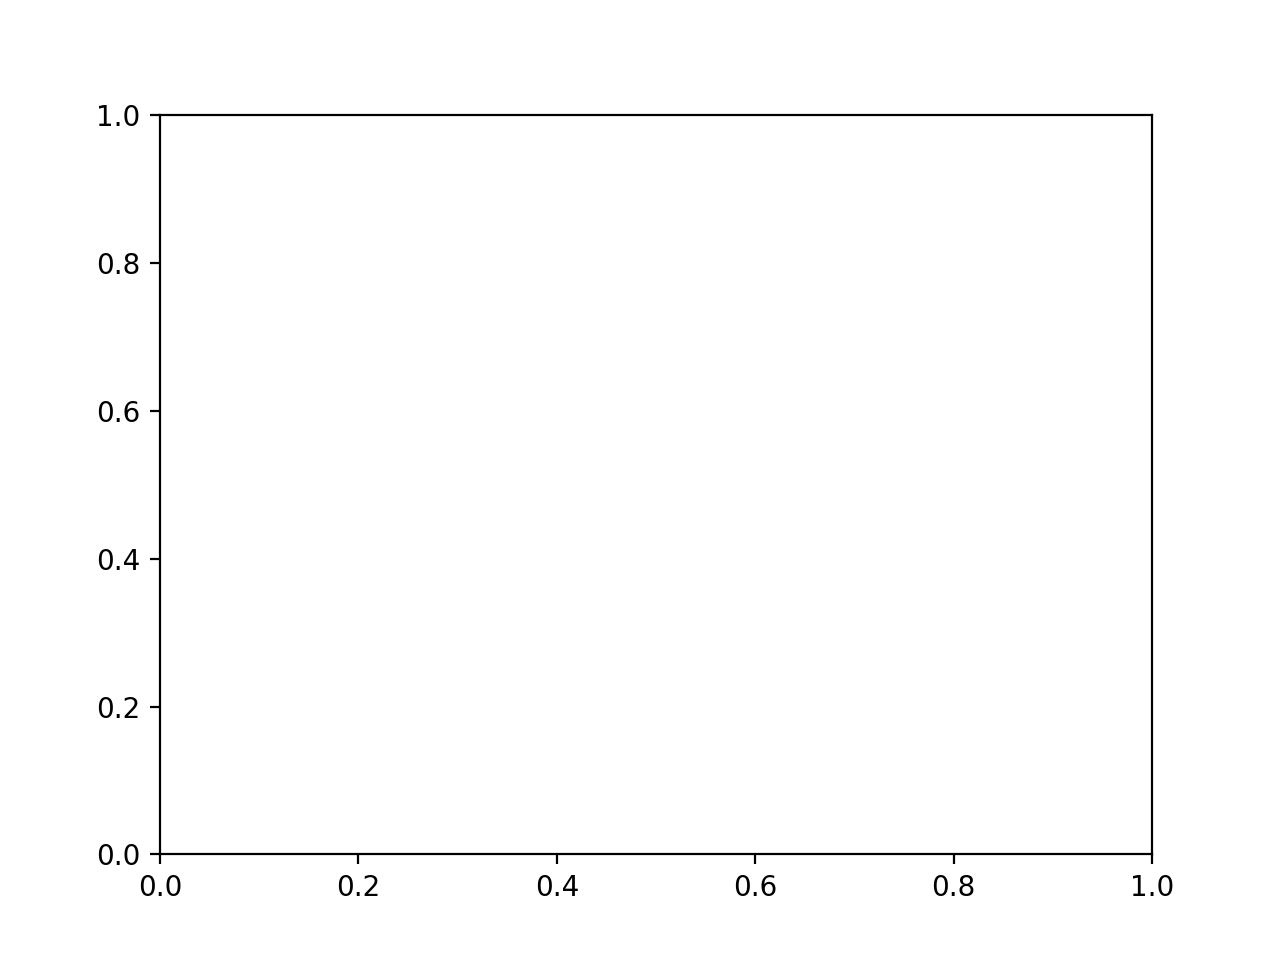

ValueError: x and y must have same first dimension, but have shapes (1000,) and (10000,)

In [55]:
plt.plot(range(1000), ref_traj[10000:20000, 0])

In [21]:
start = times[0::2]
end = times[1::2]

ref_traj1 = []
actual_traj1 = []

for i in range(len(start)):
    ref_traj1.append(ref_traj[start[i]:end[i], :])
    actual_traj1.append(actual_traj[start[i]:end[i], :])
    
ref_traj1 = np.array(ref_traj1)
actual_traj1 = np.array(actual_traj1)

ref_traj1 = ref_traj1.reshape([200*300, 14])
actual_traj1 = actual_traj1.reshape([200*300, 14])

print(ref_traj1.reshape([200*300, 14]).shape)
print(actual_traj1.reshape([200*300, 14]))

ValueError: cannot reshape array of size 252000 into shape (60000,14)

In [37]:
xcost = np.linalg.norm(actual_traj[:,(0,1,2)] - ref_traj[:,(0,1,2)], axis=1)**2 
ucost = 0.1 * np.linalg.norm(input_traj, axis=1)**2
# Cost from yaw (needs special treatment because quotient norm)
ar = np.abs(actual_traj[:, 12] - ref_traj[:, 12])
ra = np.abs(actual_traj[:, 12] + 2*np.pi-ref_traj[:,12])
yawcost = np.minimum(ar, ra) ** 2
cost = xcost + yawcost + ucost

In [38]:
print(len(cost))

47964


In [39]:
print(np.mean(cost))

3.07746416008964


In [40]:
def compute_cost(start, end, cost):
    total_cost = []
    for i in range(len(start)):
        total_cost = np.append(total_cost, sum(cost[start[i]:end[i]]))
    return total_cost

In [41]:
total = compute_cost(times[0::2], times[1::2], cost)

In [42]:
print(len(total))

100


In [43]:
print(total)

[1058.3271382   870.13150013 1018.29397396 1058.63913013 1006.28979963
 1023.70411695 1012.50025707 1020.79662659 1013.85920993 1015.42930037
 1022.87274909 1021.35790015 1021.56099691 1025.43287993 1032.18138156
 1040.59165637 1050.42781749 1056.24520067 1058.77878183 1057.40590187
  833.62106056  806.88593425  828.4324602   815.69852002  778.19057803
  833.7644848   812.66048235  835.82918669  837.04805663  812.20567048
  853.4347112   822.17797709  846.18316675  826.32974569  853.72741871
  849.26011921  839.5771391   858.52818862  836.19836955  856.20768891
 1018.13485417 1024.81129175 1079.69586941 1024.22667882 1006.97680391
 1084.10653866 1035.98365434 1042.18833333 1104.28676336 1014.5627545
 1051.64404374 1070.2879975  1039.54481536 1066.13514789 1119.06838525
 1144.17393195 1123.46815859 1103.81786242 1123.15445486 1138.19965315
  949.27896772  942.14417354  952.40026794  913.28009273  799.94938208
  956.70578356  953.60273755  971.57615145  944.35685792  827.69794889
  983.4

<IPython.core.display.Javascript object>


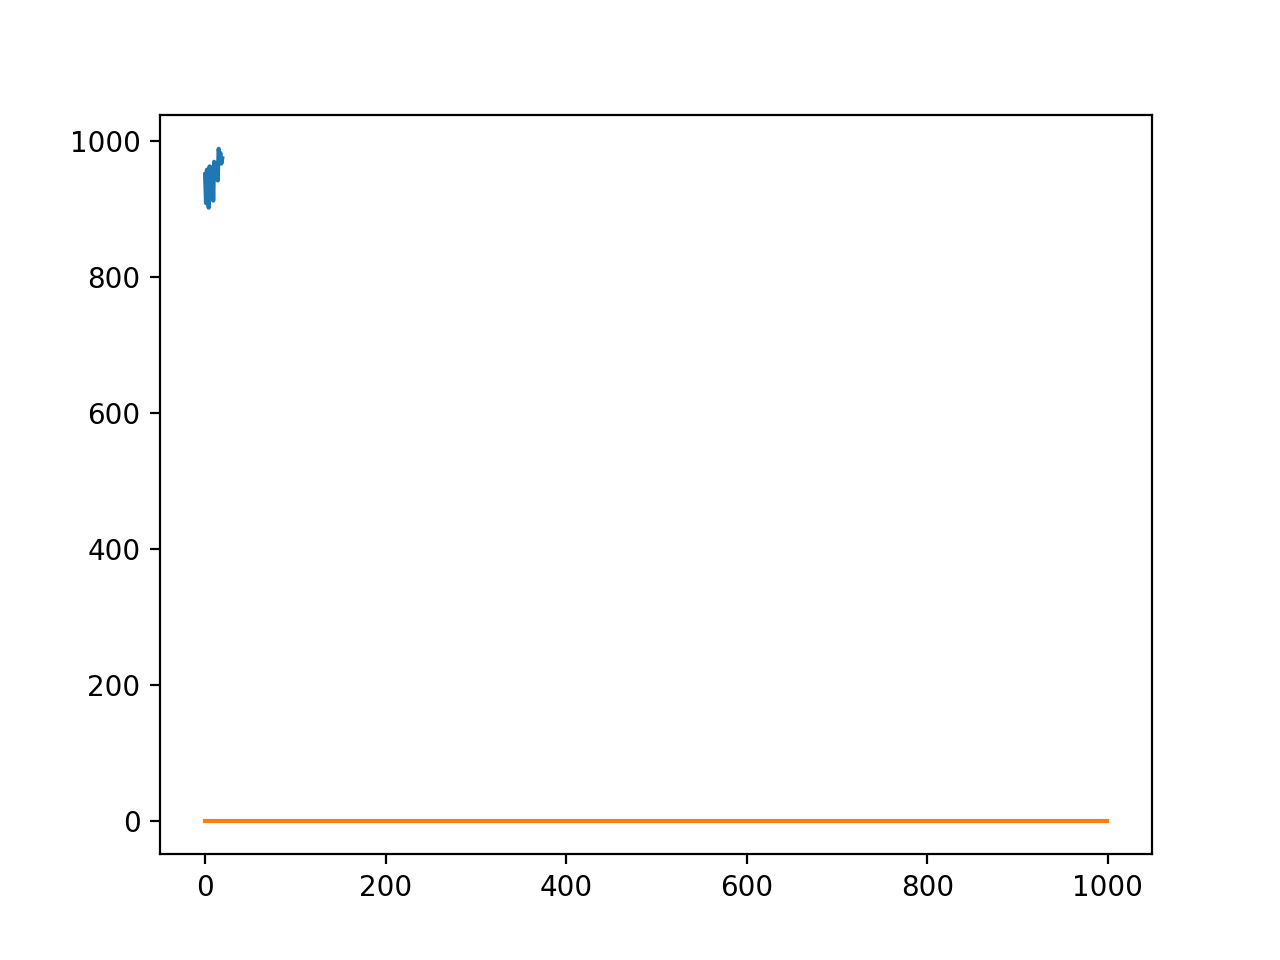

In [47]:
plt.plot(range(0, 20), total.reshape([5, 20]).mean(0))
#plt.plot(range(0, 20), total[100:120])

In [40]:
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [41]:
save_object(total, '/home/anusha/Downloads/icra_results/fig2_costs.pkl')